# 1. Import Libraries and Setup

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU, SimpleRNN, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
import os
from datetime import datetime
import json
from itertools import product
import optuna
import time

warnings.filterwarnings("ignore")

c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 2. Initialize Global Variables and Helper Functions

In [2]:
SEQUENCE_LENGTH = 12  # 12 months lookback
MODEL_DIR = 'cinnamon_models'

# Create model directory if it doesn't exist
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)
    print(f"Created model directory: {MODEL_DIR}")

# Initialize preprocessors
scaler_features = StandardScaler()
scaler_target = StandardScaler()
label_encoders = {}

# 3.Data Loading and Preparation Functions 

In [3]:
def load_and_prepare_data(data_path):
    """Load and prepare the cinnamon price dataset"""
    # Load data
    print(f"Loading data from {data_path}...")
    df = pd.read_csv(data_path)
    print(f"Initial data shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")

    # Convert Month to datetime
    df['Month'] = pd.to_datetime(df['Month'])

    # Handle missing values in Regional_Price
    missing_before = df['Regional_Price'].isna().sum()
    df.loc[df['Is_Active_Region'] == 0, 'Regional_Price'] = df.loc[df['Is_Active_Region'] == 0, 'National_Price']
    missing_after = df['Regional_Price'].isna().sum()
    print(f"Missing Regional_Price values: {missing_before} -> {missing_after}")

    # Encode categorical variables
    for col in ['Grade', 'Region']:
        if col not in label_encoders:
            label_encoders[col] = LabelEncoder()
        df[f'{col}_encoded'] = label_encoders[col].fit_transform(df[col])

    # Create additional time-based features
    df['Year'] = df['Month'].dt.year
    df['Month_num'] = df['Month'].dt.month
    df['Quarter'] = df['Month'].dt.quarter

    print("Creating lag and rolling features...")

    # Create lag features for key variables
    df = df.sort_values(['Grade', 'Region', 'Month'])
    lag_columns = ['Regional_Price', 'National_Price', 'Temperature', 'Rainfall']
    for col in lag_columns:
        if col in df.columns:
            for lag in [1, 3, 6, 12]:
                df[f'{col}_lag_{lag}'] = df.groupby(['Grade', 'Region'])[col].shift(lag)

    # Create rolling averages
    for col in ['Regional_Price', 'Temperature', 'Rainfall']:
        if col in df.columns:
            for window in [3, 6, 12]:
                df[f'{col}_rolling_{window}'] = df.groupby(['Grade', 'Region'])[col].transform(
                    lambda x: x.rolling(window).mean()
                )

    print(f"Final data shape after feature engineering: {df.shape}")
    print(f"Unique grades: {df['Grade'].unique()}")
    print(f"Unique regions: {df['Region'].unique()}")

    return df

# 4. Load Data

In [4]:
DATA_PATH = 'C:/VERGER/Spice_Price_Prediction/Cinnamon/Datasets/Cinnamon_Dataset_New_0001_Filled.csv'

df = load_and_prepare_data(DATA_PATH)
print("\nData loaded successfully!")
print(f"Shape: {df.shape}")
print("\nFirst few rows:")
df.head()

Loading data from C:/VERGER/Spice_Price_Prediction/Cinnamon/Datasets/Cinnamon_Dataset_New_0001_Filled.csv...
Initial data shape: (2898, 16)
Columns: ['Month', 'Grade', 'Region', 'Is_Active_Region', 'Regional_Price', 'National_Price', 'Seasonal_Impact', 'Local_Production_Volume', 'Local_Export_Volume', 'Global_Production_Volume', 'Global_Consumption_Volume', 'Temperature', 'Rainfall', 'Exchange_Rate', 'Inflation_Rate', 'Fuel_Price']
Missing Regional_Price values: 0 -> 0
Creating lag and rolling features...
Final data shape after feature engineering: (2898, 46)
Unique grades: ['alba' 'c4' 'c5' 'c5sp' 'h1' 'h2' 'h_faq']
Unique regions: ['colombo' 'galle' 'hambantota' 'kalutara' 'matara' 'ratnapura']

Data loaded successfully!
Shape: (2898, 46)

First few rows:


,Month,Grade,Region,Is_Active_Region,Regional_Price,National_Price,Seasonal_Impact,Local_Production_Volume,Local_Export_Volume,Global_Production_Volume,...,Rainfall_lag_12,Regional_Price_rolling_3,Regional_Price_rolling_6,Regional_Price_rolling_12,Temperature_rolling_3,Temperature_rolling_6,Temperature_rolling_12,Rainfall_rolling_3,Rainfall_rolling_6,Rainfall_rolling_12
1,2020-01-01,alba,colombo,0,2758.19,2758.19,0,0.0,1310.5,19156,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2020-02-01,alba,colombo,0,2936.38,2936.38,0,0.0,1310.5,15757,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,2020-03-01,alba,colombo,0,3140.38,3140.38,0,0.0,1123.3,23807,...,NaN,2944.983333,NaN,NaN,26.186667,NaN,NaN,38.778000,NaN,NaN
19,2020-04-01,alba,colombo,0,2847.17,2847.17,1,1145.0,748.9,19991,...,NaN,2974.643333,NaN,NaN,27.043333,NaN,NaN,62.837667,NaN,NaN
28,2020-05-01,alba,colombo,0,2903.67,2903.67,1,2290.0,936.1,18605,...,NaN,2963.740000,NaN,NaN,27.723333,NaN,NaN,132.991333,NaN,NaN


# 5. Visualization Function 1 - Price Distribution by Grade

<Figure size 1400x800 with 0 Axes>

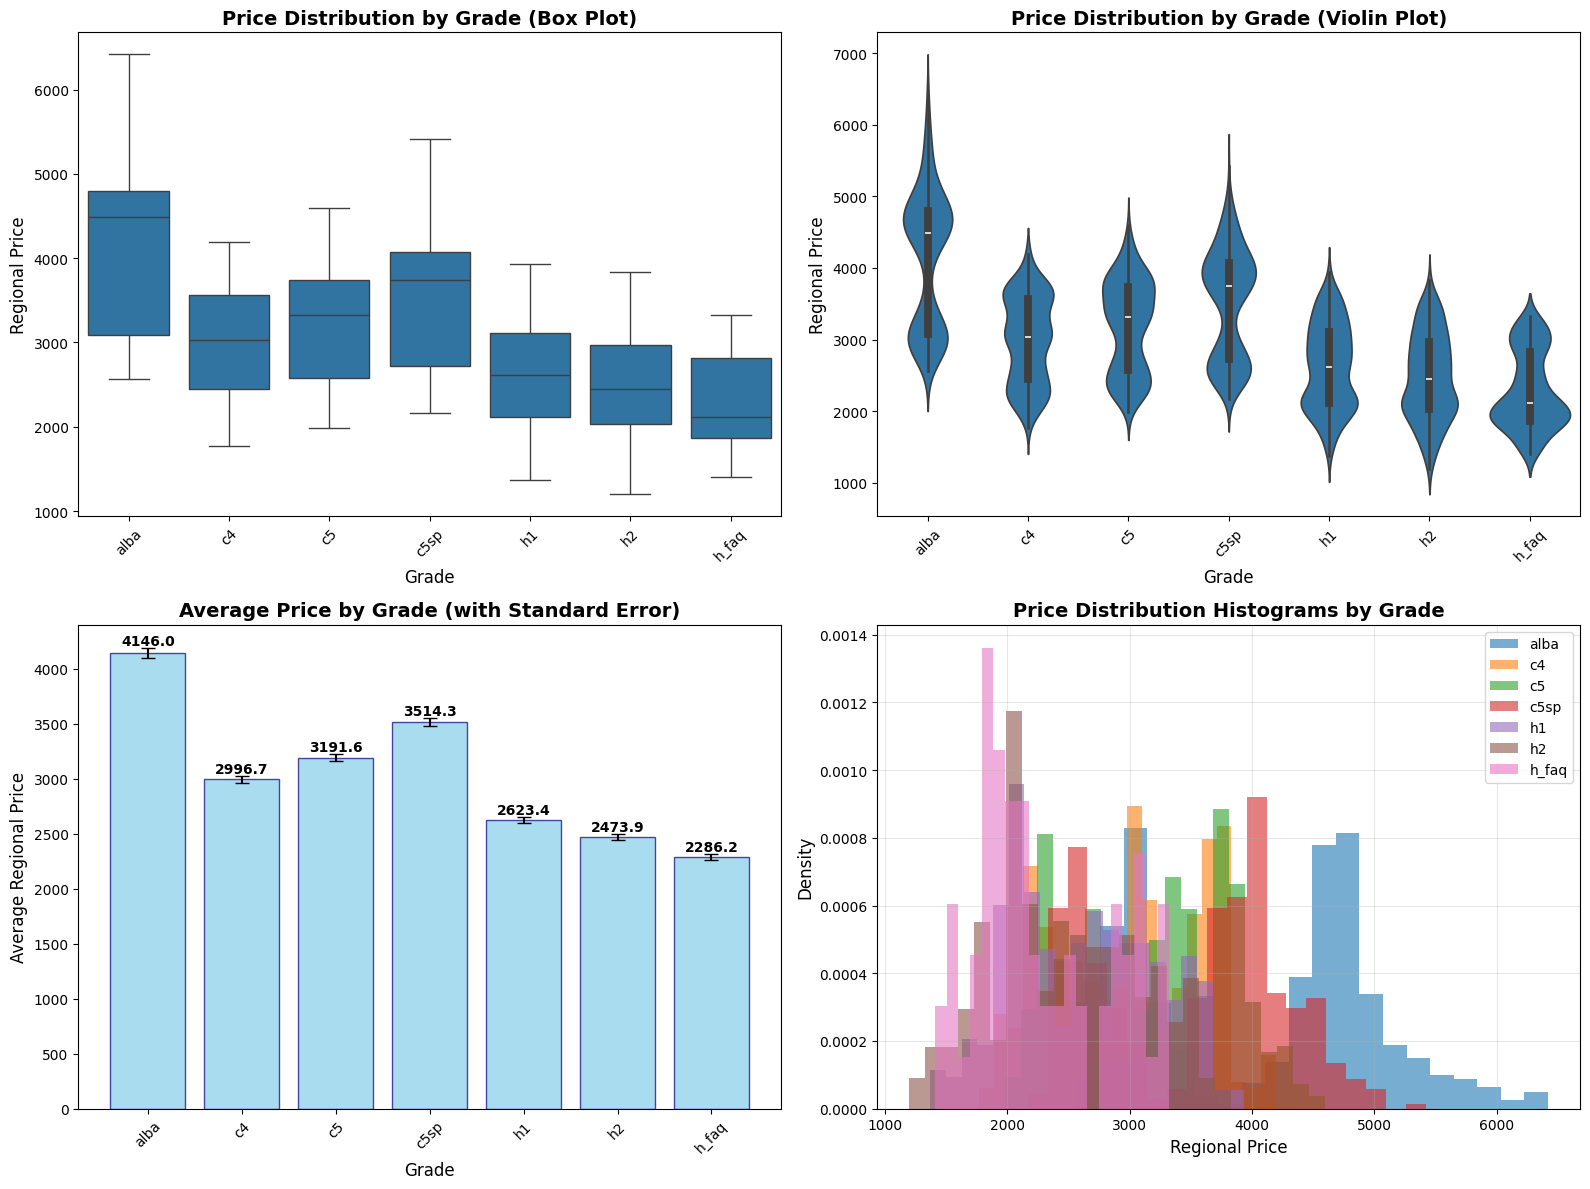


Price Distribution Summary by Grade:
       count     mean     std      min      25%      50%      75%      max
Grade                                                                     
alba   414.0  4145.98  938.87  2566.50  3083.25  4492.50  4793.75  6420.00
c4     414.0  2996.70  602.69  1766.25  2452.50  3033.22  3560.94  4197.00
c5     414.0  3191.63  639.77  1983.00  2578.50  3321.20  3736.88  4600.00
c5sp   414.0  3514.34  750.05  2166.75  2723.47  3743.88  4070.00  5419.80
h1     414.0  2623.44  589.65  1368.75  2116.54  2615.62  3109.38  3937.50
h2     414.0  2473.92  596.50  1199.75  2031.77  2450.00  2965.63  3831.25
h_faq  414.0  2286.17  537.07  1407.50  1865.00  2120.00  2821.00  3324.50


In [5]:
def plot_price_distribution_by_grade(df):
    """Plot price distribution by grade"""
    plt.figure(figsize=(14, 8))
    
    # Remove rows with missing Regional_Price
    df_clean = df.dropna(subset=['Regional_Price'])
    
    # Create subplots for different visualizations
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Box plot of prices by grade
    sns.boxplot(data=df_clean, x='Grade', y='Regional_Price', ax=ax1)
    ax1.set_title('Price Distribution by Grade (Box Plot)', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Grade', fontsize=12)
    ax1.set_ylabel('Regional Price', fontsize=12)
    ax1.tick_params(axis='x', rotation=45)
    
    # 2. Violin plot for detailed distribution
    sns.violinplot(data=df_clean, x='Grade', y='Regional_Price', ax=ax2)
    ax2.set_title('Price Distribution by Grade (Violin Plot)', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Grade', fontsize=12)
    ax2.set_ylabel('Regional Price', fontsize=12)
    ax2.tick_params(axis='x', rotation=45)
    
    # 3. Mean prices by grade with error bars
    grade_stats = df_clean.groupby('Grade')['Regional_Price'].agg(['mean', 'std', 'count']).reset_index()
    grade_stats['se'] = grade_stats['std'] / np.sqrt(grade_stats['count'])
    
    ax3.bar(grade_stats['Grade'], grade_stats['mean'], 
            yerr=grade_stats['se'], capsize=5, alpha=0.7, color='skyblue', edgecolor='navy')
    ax3.set_title('Average Price by Grade (with Standard Error)', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Grade', fontsize=12)
    ax3.set_ylabel('Average Regional Price', fontsize=12)
    ax3.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for i, (grade, mean_price) in enumerate(zip(grade_stats['Grade'], grade_stats['mean'])):
        ax3.text(i, mean_price + grade_stats['se'].iloc[i], f'{mean_price:.1f}', 
                ha='center', va='bottom', fontweight='bold')
    
    # 4. Histogram of all prices colored by grade
    for grade in df_clean['Grade'].unique():
        grade_data = df_clean[df_clean['Grade'] == grade]['Regional_Price']
        ax4.hist(grade_data, alpha=0.6, label=grade, bins=20, density=True)
    
    ax4.set_title('Price Distribution Histograms by Grade', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Regional Price', fontsize=12)
    ax4.set_ylabel('Density', fontsize=12)
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nPrice Distribution Summary by Grade:")
    print("=" * 50)
    summary_stats = df_clean.groupby('Grade')['Regional_Price'].describe()
    print(summary_stats.round(2))

plot_price_distribution_by_grade(df)

# 6.Visualization Function 2 - Feature Correlation Matrix

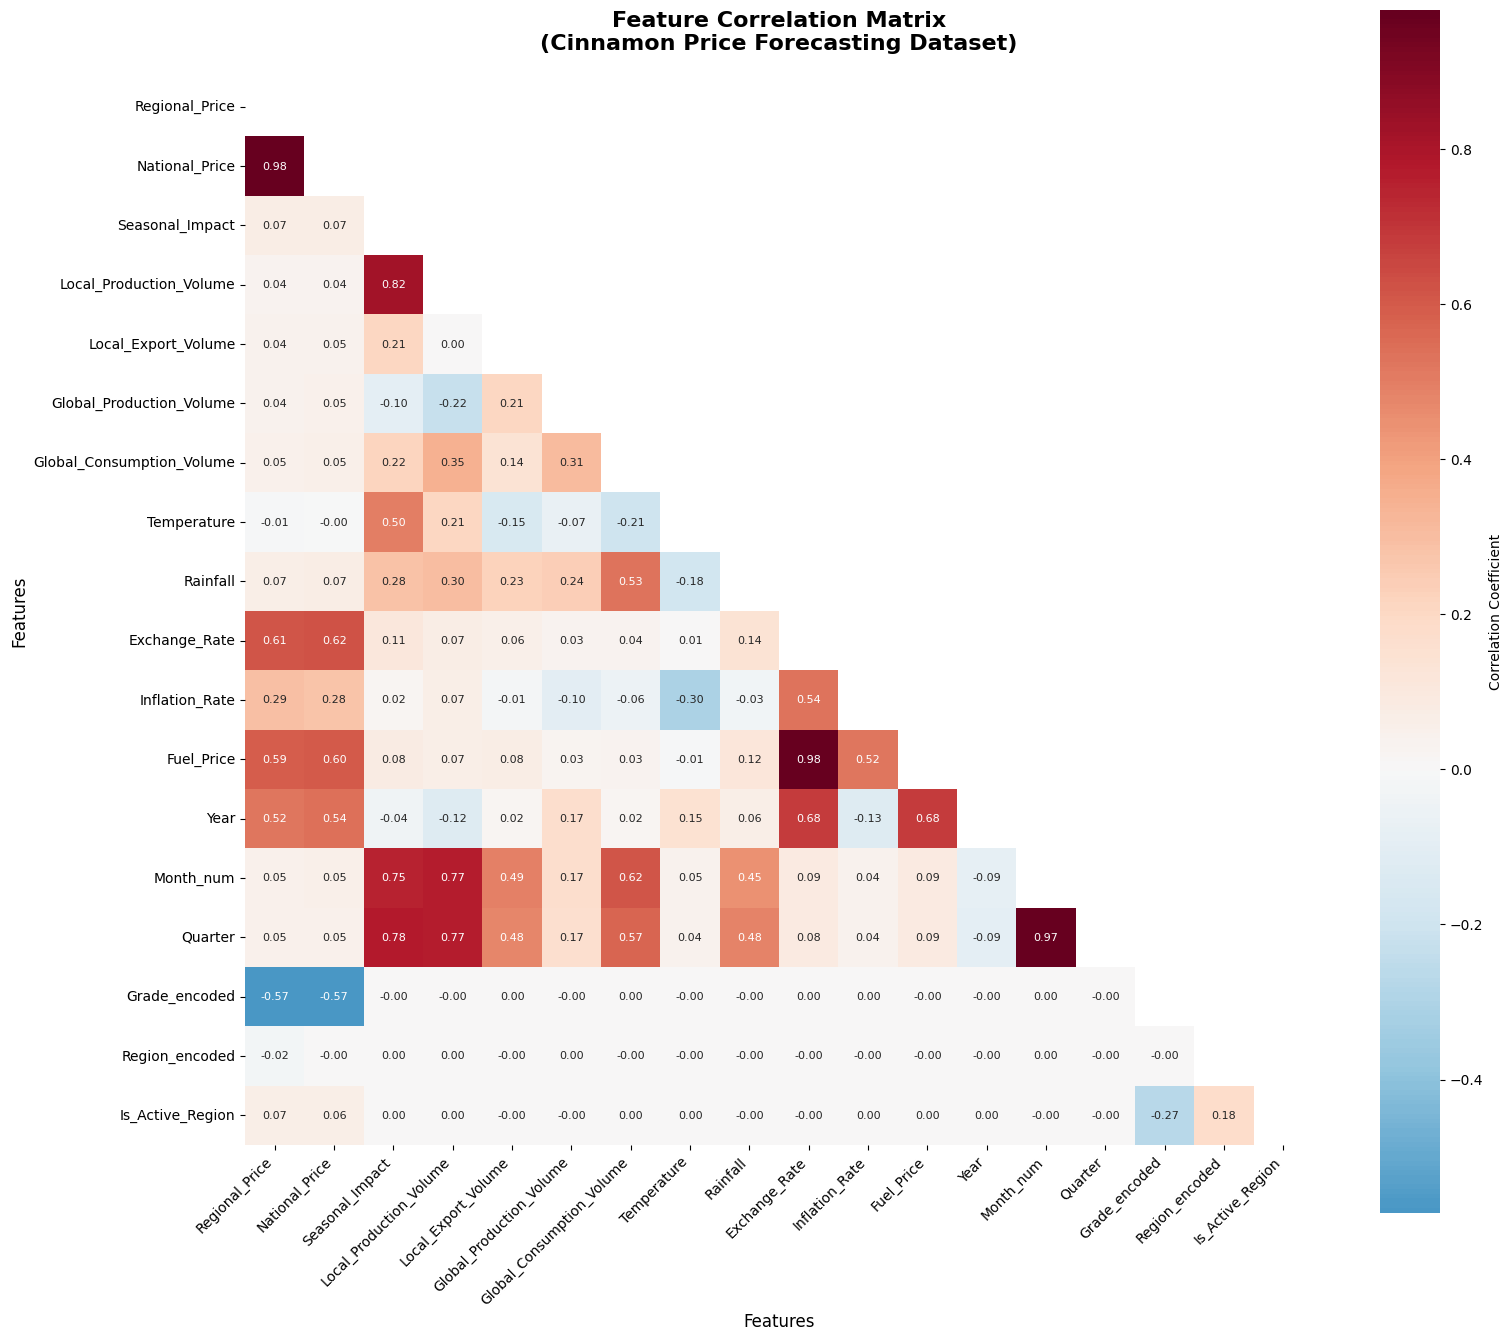


Highly Correlated Feature Pairs (|correlation| > 0.7):
Exchange_Rate ↔ Fuel_Price: 0.980
Regional_Price ↔ National_Price: 0.978
Month_num ↔ Quarter: 0.971
Seasonal_Impact ↔ Local_Production_Volume: 0.818
Seasonal_Impact ↔ Quarter: 0.776
Local_Production_Volume ↔ Quarter: 0.771
Local_Production_Volume ↔ Month_num: 0.767
Seasonal_Impact ↔ Month_num: 0.753


In [6]:
def plot_feature_correlation_matrix(df):
    """Plot feature correlation matrix"""
    # Select numeric features for correlation analysis
    numeric_features = [
        'Regional_Price', 'National_Price', 'Seasonal_Impact',
        'Local_Production_Volume', 'Local_Export_Volume',
        'Global_Production_Volume', 'Global_Consumption_Volume',
        'Temperature', 'Rainfall', 'Exchange_Rate', 'Inflation_Rate',
        'Fuel_Price', 'Year', 'Month_num', 'Quarter', 'Grade_encoded',
        'Region_encoded', 'Is_Active_Region','GRN_QTY'
    ]
    
    # Filter to only include columns that exist in the dataframe
    available_features = [col for col in numeric_features if col in df.columns]
    
    # Calculate correlation matrix
    df_numeric = df[available_features].select_dtypes(include=[np.number])
    correlation_matrix = df_numeric.corr()
    
    # Create the plot
    plt.figure(figsize=(16, 14))
    
    # Create a mask for the upper triangle
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    
    # Create heatmap
    sns.heatmap(correlation_matrix, 
                mask=mask,
                annot=True, 
                cmap='RdBu_r', 
                center=0,
                fmt='.2f',
                square=True,
                cbar_kws={'label': 'Correlation Coefficient'},
                annot_kws={'size': 8})
    
    plt.title('Feature Correlation Matrix\n(Cinnamon Price Forecasting Dataset)', 
             fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Features', fontsize=12)
    plt.ylabel('Features', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Print highly correlated feature pairs
    print("\nHighly Correlated Feature Pairs (|correlation| > 0.7):")
    print("=" * 60)
    high_corr_pairs = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            corr_val = correlation_matrix.iloc[i, j]
            if abs(corr_val) > 0.7:
                high_corr_pairs.append((
                    correlation_matrix.columns[i], 
                    correlation_matrix.columns[j], 
                    corr_val
                ))
    
    if high_corr_pairs:
        for feature1, feature2, corr in sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True):
            print(f"{feature1} ↔ {feature2}: {corr:.3f}")
    else:
        print("No feature pairs with |correlation| > 0.7 found.")

plot_feature_correlation_matrix(df)

# 7.Sequence Preparation Function for LSTM

In [7]:
def prepare_sequences(df, sequence_length=12, target_col='Regional_Price'):
    """Create sequences for LSTM training"""
    feature_cols = [
        'Grade_encoded', 'Region_encoded', 'Is_Active_Region',
        'National_Price', 'Seasonal_Impact', 'Local_Production_Volume',
        'Local_Export_Volume', 'Global_Production_Volume', 'Global_Consumption_Volume',
        'Temperature', 'Rainfall', 'Exchange_Rate', 'Inflation_Rate', 'Fuel_Price',
        'Year', 'Month_num', 'Quarter'
    ]

    # Add lag and rolling features
    lag_cols = [col for col in df.columns if 'lag_' in col or 'rolling_' in col]
    feature_cols.extend(lag_cols)

    # Instead of dropping all NaNs, fill them
    df_clean = df.copy()
    df_clean = df_clean.fillna(method='bfill').fillna(method='ffill')

    X_sequences, y_sequences, metadata = [], [], []

    for grade in df_clean['Grade'].unique():
        for region in df_clean['Region'].unique():
            subset = df_clean[(df_clean['Grade'] == grade) & (df_clean['Region'] == region)].sort_values('Month')

            if len(subset) < sequence_length + 1:
                continue

            for i in range(len(subset) - sequence_length):
                X_seq = subset.iloc[i:i + sequence_length][feature_cols].values
                y_seq = subset.iloc[i + sequence_length][target_col]

                X_sequences.append(X_seq)
                y_sequences.append(y_seq)
                metadata.append({
                    'grade': grade,
                    'region': region,
                    'date': subset.iloc[i + sequence_length]['Month']
                })

    print("Total sequences created:", len(X_sequences))
    return np.array(X_sequences), np.array(y_sequences), metadata

# 8.LSTM Model Building with Hyperparameter Tuning

In [8]:
def build_lstm_model_tunable(units1=128, units2=64, dropout1=0.2, dropout2=0.2, 
                            dense_units=32, optimizer='adam', learning_rate=0.001, 
                            layer_type='LSTM', use_batch_norm=False, input_shape=None):
    """Build tunable LSTM model with various hyperparameters"""
    model = Sequential()
    
    # Choose layer type
    if layer_type == 'LSTM':
        model.add(LSTM(units1, return_sequences=True, input_shape=input_shape))
    elif layer_type == 'GRU':
        model.add(GRU(units1, return_sequences=True, input_shape=input_shape))
    else:  # SimpleRNN
        model.add(SimpleRNN(units1, return_sequences=True, input_shape=input_shape))
    
    if use_batch_norm:
        model.add(BatchNormalization())
    
    model.add(Dropout(dropout1))
    
    # Second RNN layer
    if layer_type == 'LSTM':
        model.add(LSTM(units2, return_sequences=False))
    elif layer_type == 'GRU':
        model.add(GRU(units2, return_sequences=False))
    else:  # SimpleRNN
        model.add(SimpleRNN(units2, return_sequences=False))
    
    if use_batch_norm:
        model.add(BatchNormalization())
        
    model.add(Dropout(dropout2))
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dense(1))
    
    # Configure optimizer
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
    else:  # SGD
        opt = SGD(learning_rate=learning_rate)
    
    model.compile(optimizer=opt, loss='mse', metrics=['mae'])
    return model

# 9.Defining Tuner Class

In [9]:
class HyperparameterTuner:
    """Hyperparameter tuning class using multiple strategies"""
    
    def __init__(self, X_train, y_train, X_val, y_val, input_shape):
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        self.input_shape = input_shape
        self.best_params = None
        self.best_score = float('inf')
        self.tuning_results = []
    
    def grid_search_tuning(self, param_grid=None, max_trials=20):
        """Grid search hyperparameter tuning"""
        print("\n🔍 Starting Grid Search Hyperparameter Tuning...")
        print("=" * 60)
        
        if param_grid is None:
            param_grid = {
                'units1': [64, 128, 256, 512, 1024],
                'units2': [32, 64, 128, 256, 512],
                'dropout1': [0.1, 0.2, 0.3, 0.4, 0.5],
                'dropout2': [0.1, 0.2, 0.3, 0.4, 0.5],
                'dense_units': [16, 32, 64, 128, 256],
                'learning_rate': [0.001, 0.0005, 0.002, 0.005, 0.01],
                'layer_type': ['LSTM', 'GRU'],
                'use_batch_norm': [True, False]
            }
        
        # Generate all combinations and sample randomly if too many
        param_combinations = list(product(*param_grid.values()))
        if len(param_combinations) > max_trials:
            param_combinations = np.random.choice(
                param_combinations, size=max_trials, replace=False
            )
        
        print(f"Testing {len(param_combinations)} parameter combinations...")
        
        best_val_loss = float('inf')
        best_params = None
        
        for i, params in enumerate(param_combinations[:max_trials]):
            param_dict = dict(zip(param_grid.keys(), params))
            
            try:
                print(f"\nTrial {i+1}/{min(len(param_combinations), max_trials)}: {param_dict}")
                
                # Build and train model
                model = build_lstm_model_tunable(**param_dict, input_shape=self.input_shape)
                
                history = model.fit(
                    self.X_train, self.y_train,
                    validation_data=(self.X_val, self.y_val),
                    epochs=30,
                    batch_size=32,
                    verbose=0,
                    callbacks=[
                        EarlyStopping(patience=5, restore_best_weights=True),
                        ReduceLROnPlateau(patience=3, factor=0.5, verbose=0)
                    ]
                )
                
                val_loss = min(history.history['val_loss'])
                
                result = {
                    'trial': i+1,
                    'params': param_dict.copy(),
                    'val_loss': val_loss,
                    'val_mae': min(history.history['val_mae'])
                }
                
                self.tuning_results.append(result)
                
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_params = param_dict.copy()
                    print(f"✅ New best validation loss: {val_loss:.6f}")
                else:
                    print(f"   Validation loss: {val_loss:.6f}")
                
                # Clean up
                del model
                tf.keras.backend.clear_session()
                
            except Exception as e:
                print(f"❌ Trial {i+1} failed: {e}")
                continue
        
        self.best_params = best_params
        self.best_score = best_val_loss
        
        print(f"\n🎉 Grid Search Complete!")
        print(f"Best validation loss: {best_val_loss:.6f}")
        print(f"Best parameters: {best_params}")
        
        return best_params, best_val_loss
    
    def optuna_tuning(self, n_trials=50):
        """Optuna-based hyperparameter tuning"""
        print("\n🎯 Starting Optuna Hyperparameter Tuning...")
        print("=" * 60)
        
        def objective(trial):
            # Define hyperparameter search space
            params = {
                'units1': trial.suggest_categorical('units1', [64, 128, 256, 512]),
                'units2': trial.suggest_categorical('units2', [32, 64, 128, 256]),
                'dropout1': trial.suggest_float('dropout1', 0.1, 0.5, step=0.1),
                'dropout2': trial.suggest_float('dropout2', 0.1, 0.5, step=0.1),
                'dense_units': trial.suggest_categorical('dense_units', [16, 32, 64, 128]),
                'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-2),
                'layer_type': trial.suggest_categorical('layer_type', ['LSTM', 'GRU']),
                'use_batch_norm': trial.suggest_categorical('use_batch_norm', [True, False]),
                'optimizer': trial.suggest_categorical('optimizer', ['adam', 'rmsprop'])
            }
            
            try:
                model = build_lstm_model_tunable(**params, input_shape=self.input_shape)
                
                history = model.fit(
                    self.X_train, self.y_train,
                    validation_data=(self.X_val, self.y_val),
                    epochs=25,
                    batch_size=32,
                    verbose=0,
                    callbacks=[
                        EarlyStopping(patience=5, restore_best_weights=True),
                        ReduceLROnPlateau(patience=3, factor=0.5, verbose=0)
                    ]
                )
                
                val_loss = min(history.history['val_loss'])
                
                # Clean up
                del model
                tf.keras.backend.clear_session()
                
                return val_loss
                
            except Exception as e:
                print(f"Trial failed: {e}")
                return float('inf')
        
        # Create study and optimize
        study = optuna.create_study(direction='minimize')
        study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
        
        self.best_params = study.best_params
        self.best_score = study.best_value
        
        print(f"\n🎉 Optuna Tuning Complete!")
        print(f"Best validation loss: {study.best_value:.6f}")
        print(f"Best parameters: {study.best_params}")
        
        # Plot optimization history
        self.plot_optuna_results(study)
        
        return study.best_params, study.best_value
    
    def plot_optuna_results(self, study):
        """Plot Optuna optimization results"""
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
        
        # Plot optimization history
        trials = study.trials
        values = [t.value for t in trials if t.value is not None]
        ax1.plot(values, marker='o', alpha=0.7)
        ax1.set_title('Optimization History', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Trial')
        ax1.set_ylabel('Validation Loss')
        ax1.grid(True, alpha=0.3)
        
        # Plot parameter importance
        if len(study.trials) > 10:
            try:
                importance = optuna.importance.get_param_importances(study)
                params = list(importance.keys())
                importances = list(importance.values())
                
                ax2.barh(params, importances)
                ax2.set_title('Parameter Importance', fontsize=14, fontweight='bold')
                ax2.set_xlabel('Importance')
                ax2.grid(True, alpha=0.3)
            except:
                ax2.text(0.5, 0.5, 'Parameter importance\nnot available', 
                        ha='center', va='center', transform=ax2.transAxes)
        
        # Plot best value progression
        best_values = []
        current_best = float('inf')
        for trial in study.trials:
            if trial.value is not None and trial.value < current_best:
                current_best = trial.value
            best_values.append(current_best)
        
        ax3.plot(best_values, marker='o', alpha=0.7, color='green')
        ax3.set_title('Best Value Progression', fontsize=14, fontweight='bold')
        ax3.set_xlabel('Trial')
        ax3.set_ylabel('Best Validation Loss')
        ax3.grid(True, alpha=0.3)
        
        # Distribution of validation losses
        ax4.hist(values, bins=20, alpha=0.7, edgecolor='black')
        ax4.axvline(study.best_value, color='red', linestyle='--', 
                   label=f'Best: {study.best_value:.6f}')
        ax4.set_title('Distribution of Validation Losses', fontsize=14, fontweight='bold')
        ax4.set_xlabel('Validation Loss')
        ax4.set_ylabel('Frequency')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def random_search_tuning(self, n_trials=30):
        """Random search hyperparameter tuning"""
        print("\n🎲 Starting Random Search Hyperparameter Tuning...")
        print("=" * 60)
        
        best_val_loss = float('inf')
        best_params = None
        
        for i in range(n_trials):
            # Randomly sample hyperparameters
            params = {
                'units1': np.random.choice([64, 128, 256, 512]),
                'units2': np.random.choice([32, 64, 128, 256]),
                'dropout1': np.random.uniform(0.1, 0.5),
                'dropout2': np.random.uniform(0.1, 0.5),
                'dense_units': np.random.choice([16, 32, 64, 128]),
                'learning_rate': np.random.loguniform(1e-4, 1e-2),
                'layer_type': np.random.choice(['LSTM', 'GRU']),
                'use_batch_norm': np.random.choice([True, False]),
                'optimizer': np.random.choice(['adam', 'rmsprop'])
            }
            
            try:
                print(f"\nTrial {i+1}/{n_trials}: {params}")
                
                model = build_lstm_model_tunable(**params, input_shape=self.input_shape)
                
                history = model.fit(
                    self.X_train, self.y_train,
                    validation_data=(self.X_val, self.y_val),
                    epochs=25,
                    batch_size=32,
                    verbose=0,
                    callbacks=[
                        EarlyStopping(patience=5, restore_best_weights=True),
                        ReduceLROnPlateau(patience=3, factor=0.5, verbose=0)
                    ]
                )
                
                val_loss = min(history.history['val_loss'])
                
                result = {
                    'trial': i+1,
                    'params': params.copy(),
                    'val_loss': val_loss,
                    'val_mae': min(history.history['val_mae'])
                }
                
                self.tuning_results.append(result)
                
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_params = params.copy()
                    print(f"✅ New best validation loss: {val_loss:.6f}")
                else:
                    print(f"   Validation loss: {val_loss:.6f}")
                
                # Clean up
                del model
                tf.keras.backend.clear_session()
                
            except Exception as e:
                print(f"❌ Trial {i+1} failed: {e}")
                continue
        
        self.best_params = best_params
        self.best_score = best_val_loss
        
        print(f"\n🎉 Random Search Complete!")
        print(f"Best validation loss: {best_val_loss:.6f}")
        print(f"Best parameters: {best_params}")
        
        return best_params, best_val_loss
    
    def plot_tuning_results(self):
        """Plot hyperparameter tuning results"""
        if not self.tuning_results:
            print("No tuning results to plot.")
            return
        
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
        
        # Extract data
        trials = [r['trial'] for r in self.tuning_results]
        val_losses = [r['val_loss'] for r in self.tuning_results]
        val_maes = [r['val_mae'] for r in self.tuning_results]
        
        # Plot validation loss progression
        ax1.plot(trials, val_losses, marker='o', alpha=0.7)
        ax1.set_title('Validation Loss by Trial', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Trial')
        ax1.set_ylabel('Validation Loss')
        ax1.grid(True, alpha=0.3)
        
        # Plot validation MAE progression
        ax2.plot(trials, val_maes, marker='s', alpha=0.7, color='orange')
        ax2.set_title('Validation MAE by Trial', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Trial')
        ax2.set_ylabel('Validation MAE')
        ax2.grid(True, alpha=0.3)
        
        # Histogram of validation losses
        ax3.hist(val_losses, bins=15, alpha=0.7, edgecolor='black')
        ax3.axvline(self.best_score, color='red', linestyle='--', 
                   label=f'Best: {self.best_score:.6f}')
        ax3.set_title('Distribution of Validation Losses', fontsize=14, fontweight='bold')
        ax3.set_xlabel('Validation Loss')
        ax3.set_ylabel('Frequency')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # Best value progression
        best_so_far = []
        current_best = float('inf')
        for loss in val_losses:
            if loss < current_best:
                current_best = loss
            best_so_far.append(current_best)
        
        ax4.plot(trials, best_so_far, marker='o', alpha=0.7, color='green')
        ax4.set_title('Best Validation Loss Progression', fontsize=14, fontweight='bold')
        ax4.set_xlabel('Trial')
        ax4.set_ylabel('Best Validation Loss')
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()


# 10.Perform Hyperparameter Tuning

In [10]:
def perform_hyperparameter_tuning(X_train, y_train, X_val, y_val, input_shape, 
                                 method='optuna', n_trials=30):
    """Main function to perform hyperparameter tuning"""
    print(f"\n🚀 Starting Hyperparameter Tuning using {method.upper()} method...")
    
    tuner = HyperparameterTuner(X_train, y_train, X_val, y_val, input_shape)
    
    if method == 'optuna':
        best_params, best_score = tuner.optuna_tuning(n_trials=n_trials)
    elif method == 'random':
        best_params, best_score = tuner.random_search_tuning(n_trials=n_trials)
    else:
        raise ValueError("Method must be 'optuna', 'grid', or 'random'")
    
    # Plot results
    if method in ['grid', 'random']:
        tuner.plot_tuning_results()
    
    return best_params, best_score, tuner

# 11. LSTM Model Building Function

In [11]:
def build_lstm_model(input_shape, best_params=None):
    """Build LSTM model with optional best parameters from tuning"""
    if best_params is None:
        # Default parameters
        best_params = {
            'units1': 128,
            'units2': 64,
            'dropout1': 0.2,
            'dropout2': 0.2,
            'dense_units': 32,
            'optimizer': 'adam',
            'learning_rate': 0.001,
            'layer_type': 'LSTM',
            'use_batch_norm': False
        }
    
    return build_lstm_model_tunable(**best_params, input_shape=input_shape)

# 12. Training History Visualization Function

In [12]:
def plot_training_history(history):
    """Plot training vs validation loss"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot training & validation loss
    ax1.plot(history.history['loss'], label='Training Loss', linewidth=2, color='blue')
    ax1.plot(history.history['val_loss'], label='Validation Loss', linewidth=2, color='red')
    ax1.set_title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss (MSE)', fontsize=12)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot training & validation MAE
    ax2.plot(history.history['mae'], label='Training MAE', linewidth=2, color='blue')
    ax2.plot(history.history['val_mae'], label='Validation MAE', linewidth=2, color='red')
    ax2.set_title('Model MAE Over Epochs', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('MAE', fontsize=12)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print final metrics
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]
    final_train_mae = history.history['mae'][-1]
    final_val_mae = history.history['val_mae'][-1]
    
    print(f"\nFinal Training Metrics:")
    print(f"Training Loss: {final_train_loss:.4f}")
    print(f"Validation Loss: {final_val_loss:.4f}")
    print(f"Training MAE: {final_train_mae:.4f}")
    print(f"Validation MAE: {final_val_mae:.4f}")

# 13.Model Training Function

In [13]:

def train_model(df, use_tuning=True, tuning_method='optuna', n_tuning_trials=20):
    """Train the forecasting model with optional hyperparameter tuning"""
    global scaler_features, scaler_target
    
    print("Preparing sequences...")
    X, y, metadata = prepare_sequences(df, SEQUENCE_LENGTH)

    if len(X) == 0:
        raise ValueError("No sequences could be created. Check if there's enough data.")

    print(f"Created {len(X)} sequences with shape {X.shape}")

    # Scale features and target
    print("Scaling features...")
    n_samples, n_timesteps, n_features = X.shape
    X_reshaped = X.reshape(-1, n_features)
    X_scaled_reshaped = scaler_features.fit_transform(X_reshaped)
    X_scaled = X_scaled_reshaped.reshape(n_samples, n_timesteps, n_features)

    y_scaled = scaler_target.fit_transform(y.reshape(-1, 1)).flatten()

    # Train-validation-test split
    X_temp, X_test, y_temp, y_test = train_test_split(
        X_scaled, y_scaled, test_size=0.2, random_state=42
    )
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.25, random_state=42  # 0.25 * 0.8 = 0.2 of total
    )

    print(f"Training set shape: X={X_train.shape}, y={y_train.shape}")
    print(f"Validation set shape: X={X_val.shape}, y={y_val.shape}")
    print(f"Test set shape: X={X_test.shape}, y={y_test.shape}")

    input_shape = (X_train.shape[1], X_train.shape[2])
    best_params = None
    tuner = None
    
    # Hyperparameter tuning
    if use_tuning:
        print(f"\n🔧 Performing hyperparameter tuning using {tuning_method} method...")
        best_params, best_score, tuner = perform_hyperparameter_tuning(
            X_train, y_train, X_val, y_val, input_shape, 
            method=tuning_method, n_trials=n_tuning_trials
        )
        
        print(f"\n📊 Hyperparameter Tuning Results:")
        print(f"Best validation loss: {best_score:.6f}")
        print(f"Best parameters:")
        for key, value in best_params.items():
            print(f"  {key}: {value}")
    else:
        print("\nSkipping hyperparameter tuning, using default parameters...")

    # Build and train final model with best parameters
    print("\nBuilding final model with optimized parameters...")
    model = build_lstm_model(input_shape, best_params)
    
    # Print model summary
    print("\n📋 Final Model Architecture:")
    model.summary()

    print("\nTraining final model...")
    
    # Use longer training for final model
    final_epochs = 150 if use_tuning else 100
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=final_epochs,
        batch_size=32,
        verbose=1,
        callbacks=[
            EarlyStopping(patience=15, restore_best_weights=True, verbose=1),
            ReduceLROnPlateau(patience=8, factor=0.5, verbose=1)
        ]
    )

    # Plot training history
    plot_training_history(history)

    # Evaluate model on test set
    print("\nEvaluating final model on test set...")
    y_pred = model.predict(X_test)
    y_pred_unscaled = scaler_target.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    y_test_unscaled = scaler_target.inverse_transform(y_test.reshape(-1, 1)).flatten()

    mae = mean_absolute_error(y_test_unscaled, y_pred_unscaled)
    rmse = np.sqrt(mean_squared_error(y_test_unscaled, y_pred_unscaled))
    r2 = r2_score(y_test_unscaled, y_pred_unscaled)

    print(f"\n🎯 Final Model Performance on Test Set:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2:.4f}")
    
    # Create comprehensive results dictionary
    results = {
        'mae': mae, 
        'rmse': rmse, 
        'r2': r2,
        'best_params': best_params,
        'tuning_method': tuning_method if use_tuning else None,
        'tuning_used': use_tuning,
        'epochs_trained': len(history.history['loss']),
        'final_train_loss': history.history['loss'][-1],
        'final_val_loss': history.history['val_loss'][-1]
    }
    
    # Add tuning results if available
    if tuner and hasattr(tuner, 'tuning_results'):
        results['tuning_results'] = tuner.tuning_results
    
    return model, history, results

# 14.Train the Model

🚀 STARTING MODEL TRAINING WITH HYPERPARAMETER TUNING
Preparing sequences...


[I 2025-09-25 15:35:28,591] A new study created in memory with name: no-name-8dc63187-4db7-46ab-9655-4eb11144694d


Total sequences created: 2394
Created 2394 sequences with shape (2394, 12, 42)
Scaling features...
Training set shape: X=(1436, 12, 42), y=(1436,)
Validation set shape: X=(479, 12, 42), y=(479,)
Test set shape: X=(479, 12, 42), y=(479,)

🔧 Performing hyperparameter tuning using optuna method...

🚀 Starting Hyperparameter Tuning using OPTUNA method...

🎯 Starting Optuna Hyperparameter Tuning...


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial: 0. Best value: 0.0473081:   2%|▏         | 1/50 [00:40<32:41, 40.03s/it]

[I 2025-09-25 15:36:08,626] Trial 0 finished with value: 0.047308072447776794 and parameters: {'units1': 128, 'units2': 256, 'dropout1': 0.2, 'dropout2': 0.30000000000000004, 'dense_units': 32, 'learning_rate': 0.000598445004064791, 'layer_type': 'LSTM', 'use_batch_norm': True, 'optimizer': 'adam'}. Best is trial 0 with value: 0.047308072447776794.


Best trial: 1. Best value: 0.0292531:   4%|▍         | 2/50 [02:08<54:59, 68.73s/it]

[I 2025-09-25 15:37:37,452] Trial 1 finished with value: 0.02925306372344494 and parameters: {'units1': 512, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.4, 'dense_units': 128, 'learning_rate': 0.00035273681778246564, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 1 with value: 0.02925306372344494.


Best trial: 1. Best value: 0.0292531:   6%|▌         | 3/50 [02:26<35:35, 45.44s/it]

[I 2025-09-25 15:37:55,166] Trial 2 finished with value: 0.054494764655828476 and parameters: {'units1': 64, 'units2': 64, 'dropout1': 0.5, 'dropout2': 0.5, 'dense_units': 16, 'learning_rate': 0.005598066734906824, 'layer_type': 'GRU', 'use_batch_norm': True, 'optimizer': 'adam'}. Best is trial 1 with value: 0.02925306372344494.


Best trial: 1. Best value: 0.0292531:   8%|▊         | 4/50 [03:40<43:30, 56.75s/it]

[I 2025-09-25 15:39:09,266] Trial 3 finished with value: 0.05296828970313072 and parameters: {'units1': 512, 'units2': 128, 'dropout1': 0.1, 'dropout2': 0.30000000000000004, 'dense_units': 128, 'learning_rate': 0.0001591195744170832, 'layer_type': 'GRU', 'use_batch_norm': True, 'optimizer': 'rmsprop'}. Best is trial 1 with value: 0.02925306372344494.


Best trial: 1. Best value: 0.0292531:  10%|█         | 5/50 [04:01<32:53, 43.86s/it]

[I 2025-09-25 15:39:30,276] Trial 4 finished with value: 0.038422808051109314 and parameters: {'units1': 128, 'units2': 64, 'dropout1': 0.4, 'dropout2': 0.5, 'dense_units': 16, 'learning_rate': 0.0006427652719295206, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 1 with value: 0.02925306372344494.


Best trial: 5. Best value: 0.0286264:  12%|█▏        | 6/50 [04:28<28:01, 38.23s/it]

[I 2025-09-25 15:39:57,561] Trial 5 finished with value: 0.028626354411244392 and parameters: {'units1': 128, 'units2': 32, 'dropout1': 0.1, 'dropout2': 0.2, 'dense_units': 128, 'learning_rate': 0.0005562988523471271, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 5 with value: 0.028626354411244392.


Best trial: 5. Best value: 0.0286264:  14%|█▍        | 7/50 [05:09<27:58, 39.03s/it]

[I 2025-09-25 15:40:38,238] Trial 6 finished with value: 0.06499627232551575 and parameters: {'units1': 256, 'units2': 32, 'dropout1': 0.2, 'dropout2': 0.2, 'dense_units': 16, 'learning_rate': 0.0005158138301094471, 'layer_type': 'LSTM', 'use_batch_norm': True, 'optimizer': 'adam'}. Best is trial 5 with value: 0.028626354411244392.


Best trial: 7. Best value: 0.0219889:  16%|█▌        | 8/50 [05:47<26:58, 38.55s/it]

[I 2025-09-25 15:41:15,756] Trial 7 finished with value: 0.02198890782892704 and parameters: {'units1': 64, 'units2': 256, 'dropout1': 0.2, 'dropout2': 0.2, 'dense_units': 64, 'learning_rate': 0.0024974940854653738, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 7 with value: 0.02198890782892704.


Best trial: 7. Best value: 0.0219889:  18%|█▊        | 9/50 [06:28<26:55, 39.41s/it]

[I 2025-09-25 15:41:57,067] Trial 8 finished with value: 0.03874640539288521 and parameters: {'units1': 128, 'units2': 256, 'dropout1': 0.2, 'dropout2': 0.5, 'dense_units': 128, 'learning_rate': 0.00016884913387337015, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 7 with value: 0.02198890782892704.


Best trial: 7. Best value: 0.0219889:  20%|██        | 10/50 [06:54<23:35, 35.38s/it]

[I 2025-09-25 15:42:23,421] Trial 9 finished with value: 0.03614763170480728 and parameters: {'units1': 64, 'units2': 32, 'dropout1': 0.2, 'dropout2': 0.1, 'dense_units': 16, 'learning_rate': 0.0011851168839318441, 'layer_type': 'GRU', 'use_batch_norm': True, 'optimizer': 'adam'}. Best is trial 7 with value: 0.02198890782892704.


Best trial: 7. Best value: 0.0219889:  22%|██▏       | 11/50 [07:21<21:21, 32.87s/it]

[I 2025-09-25 15:42:50,592] Trial 10 finished with value: 0.023325832560658455 and parameters: {'units1': 64, 'units2': 128, 'dropout1': 0.30000000000000004, 'dropout2': 0.1, 'dense_units': 64, 'learning_rate': 0.003743229085610429, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 7 with value: 0.02198890782892704.


Best trial: 7. Best value: 0.0219889:  24%|██▍       | 12/50 [07:49<19:47, 31.25s/it]

[I 2025-09-25 15:43:18,140] Trial 11 finished with value: 0.02248937264084816 and parameters: {'units1': 64, 'units2': 128, 'dropout1': 0.30000000000000004, 'dropout2': 0.1, 'dense_units': 64, 'learning_rate': 0.004387900706791517, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 7 with value: 0.02198890782892704.


Best trial: 7. Best value: 0.0219889:  26%|██▌       | 13/50 [08:10<17:19, 28.10s/it]

[I 2025-09-25 15:43:39,004] Trial 12 finished with value: 0.030287286266684532 and parameters: {'units1': 64, 'units2': 128, 'dropout1': 0.30000000000000004, 'dropout2': 0.2, 'dense_units': 64, 'learning_rate': 0.002269581783821418, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 7 with value: 0.02198890782892704.


Best trial: 7. Best value: 0.0219889:  28%|██▊       | 14/50 [08:43<17:51, 29.75s/it]

[I 2025-09-25 15:44:12,569] Trial 13 finished with value: 0.02535661868751049 and parameters: {'units1': 64, 'units2': 256, 'dropout1': 0.4, 'dropout2': 0.1, 'dense_units': 64, 'learning_rate': 0.009202014449229709, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 7 with value: 0.02198890782892704.


Best trial: 7. Best value: 0.0219889:  30%|███       | 15/50 [09:26<19:35, 33.58s/it]

[I 2025-09-25 15:44:55,030] Trial 14 finished with value: 0.024474894627928734 and parameters: {'units1': 256, 'units2': 128, 'dropout1': 0.4, 'dropout2': 0.2, 'dense_units': 64, 'learning_rate': 0.001979864143829183, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 7 with value: 0.02198890782892704.


Best trial: 7. Best value: 0.0219889:  32%|███▏      | 16/50 [09:54<18:07, 32.00s/it]

[I 2025-09-25 15:45:23,338] Trial 15 finished with value: 0.026628337800502777 and parameters: {'units1': 64, 'units2': 128, 'dropout1': 0.30000000000000004, 'dropout2': 0.1, 'dense_units': 64, 'learning_rate': 0.003654629452073217, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 7 with value: 0.02198890782892704.


Best trial: 7. Best value: 0.0219889:  34%|███▍      | 17/50 [10:32<18:35, 33.80s/it]

[I 2025-09-25 15:46:01,335] Trial 16 finished with value: 0.027563292533159256 and parameters: {'units1': 64, 'units2': 256, 'dropout1': 0.5, 'dropout2': 0.2, 'dense_units': 32, 'learning_rate': 0.0013658422743746583, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 7 with value: 0.02198890782892704.


Best trial: 7. Best value: 0.0219889:  36%|███▌      | 18/50 [10:57<16:35, 31.11s/it]

[I 2025-09-25 15:46:26,194] Trial 17 finished with value: 0.027565212920308113 and parameters: {'units1': 64, 'units2': 64, 'dropout1': 0.2, 'dropout2': 0.30000000000000004, 'dense_units': 64, 'learning_rate': 0.009268484050192037, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 7 with value: 0.02198890782892704.


Best trial: 7. Best value: 0.0219889:  38%|███▊      | 19/50 [11:49<19:14, 37.23s/it]

[I 2025-09-25 15:47:17,667] Trial 18 finished with value: 0.04117359593510628 and parameters: {'units1': 512, 'units2': 128, 'dropout1': 0.30000000000000004, 'dropout2': 0.4, 'dense_units': 64, 'learning_rate': 0.00426944951738437, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 7 with value: 0.02198890782892704.


Best trial: 19. Best value: 0.021416:  40%|████      | 20/50 [12:44<21:24, 42.82s/it]

[I 2025-09-25 15:48:13,509] Trial 19 finished with value: 0.02141600474715233 and parameters: {'units1': 256, 'units2': 256, 'dropout1': 0.4, 'dropout2': 0.1, 'dense_units': 64, 'learning_rate': 0.0022976540099169385, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 19 with value: 0.02141600474715233.


Best trial: 20. Best value: 0.0211111:  42%|████▏     | 21/50 [13:42<22:48, 47.18s/it]

[I 2025-09-25 15:49:10,877] Trial 20 finished with value: 0.021111072972416878 and parameters: {'units1': 256, 'units2': 256, 'dropout1': 0.4, 'dropout2': 0.2, 'dense_units': 32, 'learning_rate': 0.0023041537470997043, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 20 with value: 0.021111072972416878.


Best trial: 20. Best value: 0.0211111:  44%|████▍     | 22/50 [14:40<23:35, 50.57s/it]

[I 2025-09-25 15:50:09,346] Trial 21 finished with value: 0.022219683974981308 and parameters: {'units1': 256, 'units2': 256, 'dropout1': 0.4, 'dropout2': 0.2, 'dense_units': 32, 'learning_rate': 0.002174830384501515, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 20 with value: 0.021111072972416878.


Best trial: 20. Best value: 0.0211111:  46%|████▌     | 23/50 [15:36<23:31, 52.28s/it]

[I 2025-09-25 15:51:05,596] Trial 22 finished with value: 0.022891690954566002 and parameters: {'units1': 256, 'units2': 256, 'dropout1': 0.5, 'dropout2': 0.2, 'dense_units': 32, 'learning_rate': 0.0017296769814200928, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 20 with value: 0.021111072972416878.


Best trial: 20. Best value: 0.0211111:  48%|████▊     | 24/50 [16:33<23:12, 53.57s/it]

[I 2025-09-25 15:52:02,178] Trial 23 finished with value: 0.02617298997938633 and parameters: {'units1': 256, 'units2': 256, 'dropout1': 0.4, 'dropout2': 0.1, 'dense_units': 32, 'learning_rate': 0.0027605266442098735, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 20 with value: 0.021111072972416878.


Best trial: 20. Best value: 0.0211111:  50%|█████     | 25/50 [17:30<22:42, 54.48s/it]

[I 2025-09-25 15:52:58,802] Trial 24 finished with value: 0.023513464257121086 and parameters: {'units1': 256, 'units2': 256, 'dropout1': 0.4, 'dropout2': 0.30000000000000004, 'dense_units': 32, 'learning_rate': 0.0012041644489427631, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 20 with value: 0.021111072972416878.


Best trial: 20. Best value: 0.0211111:  52%|█████▏    | 26/50 [18:28<22:13, 55.55s/it]

[I 2025-09-25 15:53:56,847] Trial 25 finished with value: 0.022545216605067253 and parameters: {'units1': 256, 'units2': 256, 'dropout1': 0.5, 'dropout2': 0.2, 'dense_units': 64, 'learning_rate': 0.0008876903918386811, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 20 with value: 0.021111072972416878.


Best trial: 20. Best value: 0.0211111:  54%|█████▍    | 27/50 [19:32<22:20, 58.30s/it]

[I 2025-09-25 15:55:01,559] Trial 26 finished with value: 0.029450371861457825 and parameters: {'units1': 256, 'units2': 256, 'dropout1': 0.4, 'dropout2': 0.1, 'dense_units': 64, 'learning_rate': 0.005805068538584027, 'layer_type': 'LSTM', 'use_batch_norm': True, 'optimizer': 'rmsprop'}. Best is trial 20 with value: 0.021111072972416878.


Best trial: 20. Best value: 0.0211111:  56%|█████▌    | 28/50 [20:29<21:10, 57.73s/it]

[I 2025-09-25 15:55:57,959] Trial 27 finished with value: 0.023772362619638443 and parameters: {'units1': 256, 'units2': 256, 'dropout1': 0.30000000000000004, 'dropout2': 0.4, 'dense_units': 32, 'learning_rate': 0.0009113930264044403, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 20 with value: 0.021111072972416878.


Best trial: 20. Best value: 0.0211111:  58%|█████▊    | 29/50 [21:26<20:06, 57.46s/it]

[I 2025-09-25 15:56:54,792] Trial 28 finished with value: 0.02583303302526474 and parameters: {'units1': 256, 'units2': 256, 'dropout1': 0.5, 'dropout2': 0.2, 'dense_units': 64, 'learning_rate': 0.0029007117864474383, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 20 with value: 0.021111072972416878.


Best trial: 20. Best value: 0.0211111:  60%|██████    | 30/50 [23:24<25:15, 75.76s/it]

[I 2025-09-25 15:58:53,245] Trial 29 finished with value: 0.035877954214811325 and parameters: {'units1': 512, 'units2': 256, 'dropout1': 0.2, 'dropout2': 0.30000000000000004, 'dense_units': 32, 'learning_rate': 0.0015589613665150295, 'layer_type': 'LSTM', 'use_batch_norm': True, 'optimizer': 'rmsprop'}. Best is trial 20 with value: 0.021111072972416878.


Best trial: 20. Best value: 0.0211111:  62%|██████▏   | 31/50 [24:07<20:51, 65.87s/it]

[I 2025-09-25 15:59:36,033] Trial 30 finished with value: 0.03692511469125748 and parameters: {'units1': 128, 'units2': 256, 'dropout1': 0.4, 'dropout2': 0.1, 'dense_units': 32, 'learning_rate': 0.00010357703311345486, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 20 with value: 0.021111072972416878.


Best trial: 20. Best value: 0.0211111:  64%|██████▍   | 32/50 [25:04<18:56, 63.13s/it]

[I 2025-09-25 16:00:32,773] Trial 31 finished with value: 0.02271869219839573 and parameters: {'units1': 256, 'units2': 256, 'dropout1': 0.4, 'dropout2': 0.2, 'dense_units': 32, 'learning_rate': 0.0023523899650410404, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 20 with value: 0.021111072972416878.


Best trial: 20. Best value: 0.0211111:  66%|██████▌   | 33/50 [26:00<17:18, 61.09s/it]

[I 2025-09-25 16:01:29,102] Trial 32 finished with value: 0.02374717779457569 and parameters: {'units1': 256, 'units2': 256, 'dropout1': 0.4, 'dropout2': 0.30000000000000004, 'dense_units': 32, 'learning_rate': 0.003188787411342662, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 20 with value: 0.021111072972416878.


Best trial: 20. Best value: 0.0211111:  68%|██████▊   | 34/50 [26:58<16:02, 60.14s/it]

[I 2025-09-25 16:02:27,040] Trial 33 finished with value: 0.02649109810590744 and parameters: {'units1': 256, 'units2': 256, 'dropout1': 0.4, 'dropout2': 0.2, 'dense_units': 32, 'learning_rate': 0.006187303922018361, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 20 with value: 0.021111072972416878.


Best trial: 20. Best value: 0.0211111:  70%|███████   | 35/50 [27:17<11:58, 47.92s/it]

[I 2025-09-25 16:02:46,445] Trial 34 finished with value: 0.04523302987217903 and parameters: {'units1': 256, 'units2': 64, 'dropout1': 0.1, 'dropout2': 0.30000000000000004, 'dense_units': 128, 'learning_rate': 0.0019285474776575802, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 20 with value: 0.021111072972416878.


Best trial: 20. Best value: 0.0211111:  72%|███████▏  | 36/50 [29:11<15:46, 67.62s/it]

[I 2025-09-25 16:04:40,029] Trial 35 finished with value: 0.03794794902205467 and parameters: {'units1': 512, 'units2': 256, 'dropout1': 0.5, 'dropout2': 0.2, 'dense_units': 32, 'learning_rate': 0.002264982057358034, 'layer_type': 'LSTM', 'use_batch_norm': True, 'optimizer': 'rmsprop'}. Best is trial 20 with value: 0.021111072972416878.


Best trial: 20. Best value: 0.0211111:  74%|███████▍  | 37/50 [29:51<12:51, 59.37s/it]

[I 2025-09-25 16:05:20,155] Trial 36 finished with value: 0.02623462863266468 and parameters: {'units1': 256, 'units2': 32, 'dropout1': 0.30000000000000004, 'dropout2': 0.1, 'dense_units': 16, 'learning_rate': 0.0007511788781577912, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 20 with value: 0.021111072972416878.


Best trial: 20. Best value: 0.0211111:  76%|███████▌  | 38/50 [30:31<10:43, 53.60s/it]

[I 2025-09-25 16:06:00,302] Trial 37 finished with value: 0.03313001990318298 and parameters: {'units1': 256, 'units2': 64, 'dropout1': 0.4, 'dropout2': 0.4, 'dense_units': 128, 'learning_rate': 0.001619663076492206, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 20 with value: 0.021111072972416878.


Best trial: 20. Best value: 0.0211111:  78%|███████▊  | 39/50 [31:21<09:38, 52.58s/it]

[I 2025-09-25 16:06:50,486] Trial 38 finished with value: 0.03351128473877907 and parameters: {'units1': 128, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.30000000000000004, 'dense_units': 64, 'learning_rate': 0.0070079940095519825, 'layer_type': 'LSTM', 'use_batch_norm': True, 'optimizer': 'adam'}. Best is trial 20 with value: 0.021111072972416878.


Best trial: 20. Best value: 0.0211111:  80%|████████  | 40/50 [32:38<09:58, 59.89s/it]

[I 2025-09-25 16:08:07,433] Trial 39 finished with value: 0.030322270467877388 and parameters: {'units1': 512, 'units2': 32, 'dropout1': 0.5, 'dropout2': 0.2, 'dense_units': 16, 'learning_rate': 0.0003727713181639015, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 20 with value: 0.021111072972416878.


Best trial: 40. Best value: 0.0199642:  82%|████████▏ | 41/50 [33:48<09:25, 62.82s/it]

[I 2025-09-25 16:09:17,081] Trial 40 finished with value: 0.01996424049139023 and parameters: {'units1': 256, 'units2': 256, 'dropout1': 0.30000000000000004, 'dropout2': 0.2, 'dense_units': 32, 'learning_rate': 0.0011026374955312266, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 40 with value: 0.01996424049139023.


Best trial: 40. Best value: 0.0199642:  84%|████████▍ | 42/50 [34:59<08:41, 65.15s/it]

[I 2025-09-25 16:10:27,677] Trial 41 finished with value: 0.023913055658340454 and parameters: {'units1': 256, 'units2': 256, 'dropout1': 0.30000000000000004, 'dropout2': 0.2, 'dense_units': 32, 'learning_rate': 0.001154128464348885, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 40 with value: 0.01996424049139023.


Best trial: 40. Best value: 0.0199642:  86%|████████▌ | 43/50 [35:59<07:25, 63.65s/it]

[I 2025-09-25 16:11:27,826] Trial 42 finished with value: 0.021898595616221428 and parameters: {'units1': 256, 'units2': 256, 'dropout1': 0.2, 'dropout2': 0.2, 'dense_units': 32, 'learning_rate': 0.0027337291119544057, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 40 with value: 0.01996424049139023.


Best trial: 40. Best value: 0.0199642:  88%|████████▊ | 44/50 [36:55<06:08, 61.45s/it]

[I 2025-09-25 16:12:24,149] Trial 43 finished with value: 0.02037680707871914 and parameters: {'units1': 256, 'units2': 256, 'dropout1': 0.2, 'dropout2': 0.1, 'dense_units': 32, 'learning_rate': 0.004911669515736028, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 40 with value: 0.01996424049139023.


Best trial: 40. Best value: 0.0199642:  90%|█████████ | 45/50 [37:50<04:56, 59.39s/it]

[I 2025-09-25 16:13:18,732] Trial 44 finished with value: 0.022225068882107735 and parameters: {'units1': 256, 'units2': 256, 'dropout1': 0.2, 'dropout2': 0.1, 'dense_units': 32, 'learning_rate': 0.004974529917304743, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 40 with value: 0.01996424049139023.


Best trial: 40. Best value: 0.0199642:  92%|█████████▏| 46/50 [38:44<03:51, 57.81s/it]

[I 2025-09-25 16:14:12,851] Trial 45 finished with value: 0.02126782201230526 and parameters: {'units1': 256, 'units2': 256, 'dropout1': 0.2, 'dropout2': 0.1, 'dense_units': 32, 'learning_rate': 0.0034185892781884953, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 40 with value: 0.01996424049139023.


Best trial: 46. Best value: 0.0185835:  94%|█████████▍| 47/50 [39:39<02:50, 56.99s/it]

[I 2025-09-25 16:15:07,938] Trial 46 finished with value: 0.0185835100710392 and parameters: {'units1': 256, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.1, 'dense_units': 32, 'learning_rate': 0.003536146115852421, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 46 with value: 0.0185835100710392.


Best trial: 46. Best value: 0.0185835:  96%|█████████▌| 48/50 [40:19<01:43, 51.91s/it]

[I 2025-09-25 16:15:47,982] Trial 47 finished with value: 0.0345134511590004 and parameters: {'units1': 256, 'units2': 32, 'dropout1': 0.1, 'dropout2': 0.1, 'dense_units': 32, 'learning_rate': 0.0038694072830528607, 'layer_type': 'GRU', 'use_batch_norm': True, 'optimizer': 'adam'}. Best is trial 46 with value: 0.0185835100710392.


Best trial: 46. Best value: 0.0185835:  98%|█████████▊| 49/50 [40:46<00:44, 44.56s/it]

[I 2025-09-25 16:16:15,385] Trial 48 finished with value: 0.022740306332707405 and parameters: {'units1': 128, 'units2': 64, 'dropout1': 0.1, 'dropout2': 0.1, 'dense_units': 32, 'learning_rate': 0.007682643286224332, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 46 with value: 0.0185835100710392.


Best trial: 46. Best value: 0.0185835: 100%|██████████| 50/50 [41:47<00:00, 50.15s/it]


[I 2025-09-25 16:17:16,197] Trial 49 finished with value: 0.022992050275206566 and parameters: {'units1': 256, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.1, 'dense_units': 32, 'learning_rate': 0.0004610899960824842, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 46 with value: 0.0185835100710392.

🎉 Optuna Tuning Complete!
Best validation loss: 0.018584
Best parameters: {'units1': 256, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.1, 'dense_units': 32, 'learning_rate': 0.003536146115852421, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}


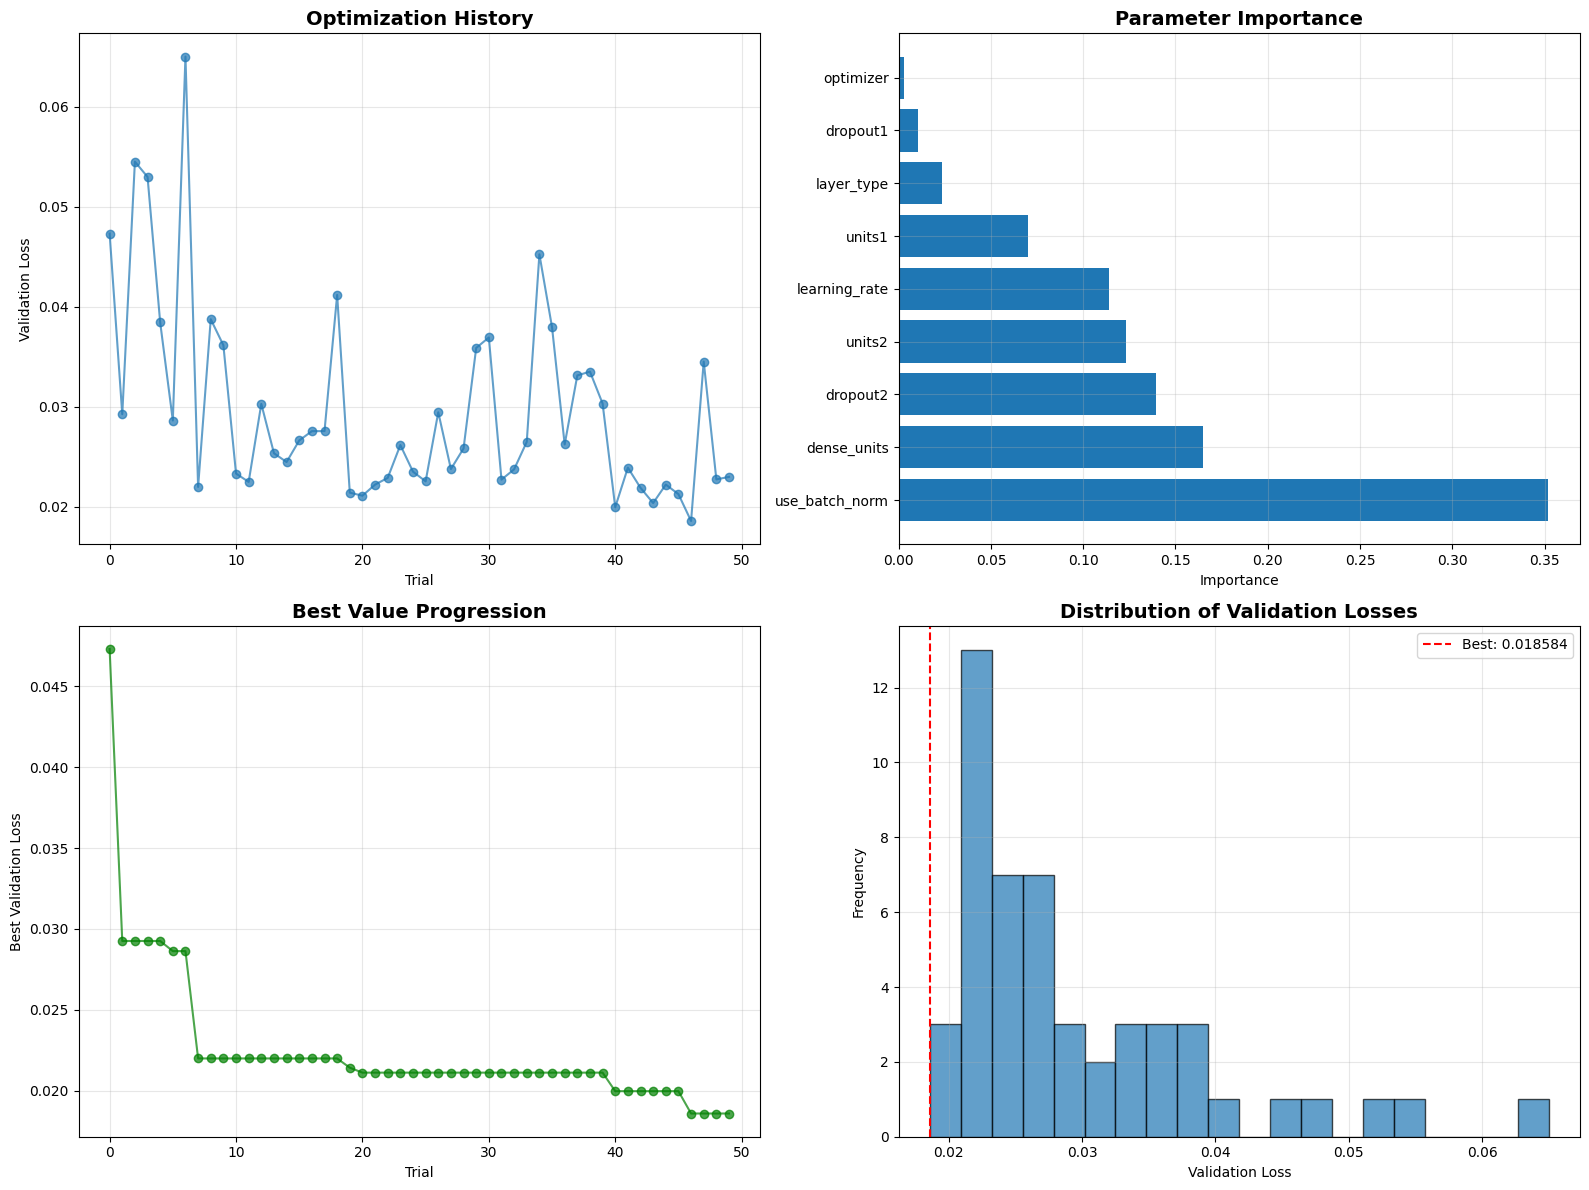


📊 Hyperparameter Tuning Results:
Best validation loss: 0.018584
Best parameters:
  units1: 256
  units2: 256
  dropout1: 0.1
  dropout2: 0.1
  dense_units: 32
  learning_rate: 0.003536146115852421
  layer_type: GRU
  use_batch_norm: False
  optimizer: adam

Building final model with optimized parameters...

📋 Final Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 12, 256)        │       230,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 256)            │       394,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 633,409 (2.42 MB)

 Trainable params: 633,409 (2.42 MB)

 Non-trainable params: 0 (0.00 B)


Training final model...
Epoch 1/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - loss: 0.3032 - mae: 0.3927 - val_loss: 0.0769 - val_mae: 0.2177 - learning_rate: 0.0035
Epoch 2/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0844 - mae: 0.2218 - val_loss: 0.0678 - val_mae: 0.2006 - learning_rate: 0.0035
Epoch 3/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0555 - mae: 0.1755 - val_loss: 0.0459 - val_mae: 0.1557 - learning_rate: 0.0035
Epoch 4/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0459 - mae: 0.1595 - val_loss: 0.0416 - val_mae: 0.1516 - learning_rate: 0.0035
Epoch 5/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 0.0469 - mae: 0.1640 - val_loss: 0.0396 - val_mae: 0.1496 - learning_rate: 0.0035
Epoch 6/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0422 - mae: 0.1523 - val_loss: 0.0554 - val_mae: 0.1761 - learning_rate: 0.0035
Epoch 7/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0371 - mae: 0.1412 - val_loss: 0.0391 - val_mae: 0.1515 - lea

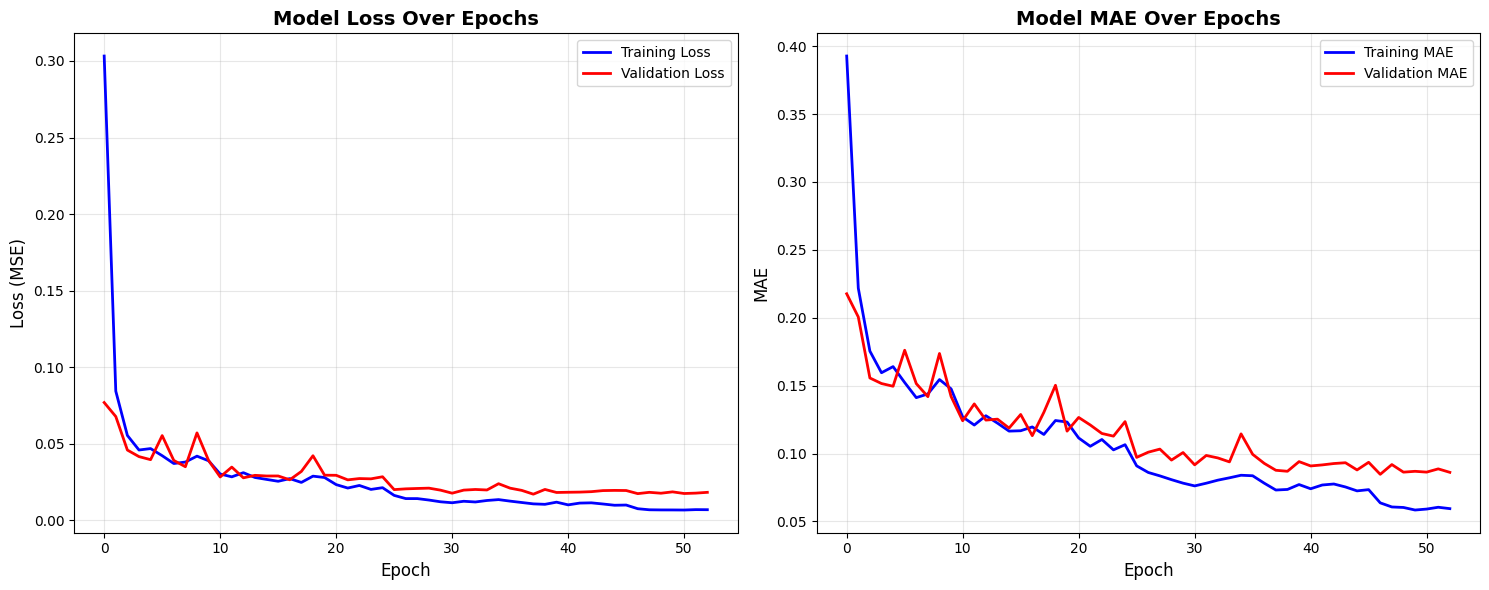


Final Training Metrics:
Training Loss: 0.0070
Validation Loss: 0.0183
Training MAE: 0.0595
Validation MAE: 0.0862

Evaluating final model on test set...
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step

🎯 Final Model Performance on Test Set:
MAE: 74.79
RMSE: 108.24
R²: 0.9841

🎉 Model training completed!


In [14]:
# Train model with hyperparameter tuning
print("🚀 STARTING MODEL TRAINING WITH HYPERPARAMETER TUNING")
print("="*80)

# You can change these parameters:
USE_HYPERPARAMETER_TUNING = True  # Set to False to skip tuning
TUNING_METHOD = 'optuna'  # Options: 'optuna', 'grid', 'random'
N_TUNING_TRIALS = 50  # Number of trials for tuning

model, history, metrics = train_model(
    df, 
    use_tuning=USE_HYPERPARAMETER_TUNING,
    tuning_method=TUNING_METHOD,
    n_tuning_trials=N_TUNING_TRIALS
)

print("\n🎉 Model training completed!")

# 15.Save the Model

In [15]:
def save_model(model, metrics, model_dir=MODEL_DIR):
    """Save the trained model and all preprocessors"""
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Create model-specific directory
    model_save_dir = os.path.join(model_dir, f"cinnamon_model_{timestamp}")
    os.makedirs(model_save_dir, exist_ok=True)
    
    print(f"\n📁 Saving model to: {model_save_dir}")
    
    try:
        # 1. Save the Keras model
        model_path = os.path.join(model_save_dir, "lstm_model.keras")
        model.save(model_path)
        print(f"✅ Keras model saved: lstm_model.keras")
        
        # 2. Save scalers
        scalers_path = os.path.join(model_save_dir, "scalers.pkl")
        scalers = {
            'scaler_features': scaler_features,
            'scaler_target': scaler_target
        }
        with open(scalers_path, 'wb') as f:
            pickle.dump(scalers, f)
        print(f"✅ Scalers saved: scalers.pkl")
        
        # 3. Save label encoders
        encoders_path = os.path.join(model_save_dir, "label_encoders.pkl")
        with open(encoders_path, 'wb') as f:
            pickle.dump(label_encoders, f)
        print(f"✅ Label encoders saved: label_encoders.pkl")
        
        # 4. Save model configuration and metadata (enhanced with tuning info)
        config = {
            'sequence_length': SEQUENCE_LENGTH,
            'model_architecture': {
                'input_shape': model.input_shape,
                'layers': [str(layer.__class__.__name__) for layer in model.layers],
                'total_params': model.count_params()
            },
            'training_info': {
                'timestamp': timestamp,
                'mae': float(metrics['mae']),
                'rmse': float(metrics['rmse']),
                'r2': float(metrics['r2']),
                'tuning_used': metrics.get('tuning_used', False),
                'tuning_method': metrics.get('tuning_method', None),
                'best_params': metrics.get('best_params', None),
                'epochs_trained': metrics.get('epochs_trained', 0),
                'final_train_loss': float(metrics.get('final_train_loss', 0)),
                'final_val_loss': float(metrics.get('final_val_loss', 0))
            }
        }
        
        # Save tuning results if available
        if 'tuning_results' in metrics and metrics['tuning_results']:
            tuning_results_path = os.path.join(model_save_dir, "tuning_results.json")
            with open(tuning_results_path, 'w') as f:
                json.dump(metrics['tuning_results'], f, indent=2, default=str)
            print(f"✅ Hyperparameter tuning results saved: tuning_results.json")
        
        config_path = os.path.join(model_save_dir, "model_config.json")
        with open(config_path, 'w') as f:
            json.dump(config, f, indent=2, default=str)
        print(f"✅ Model configuration saved: model_config.json")
        
        print(f"\n🎉 Model successfully saved to: {model_save_dir}")
        
        # Print summary of saved model
        print(f"\n📊 Saved Model Summary:")
        print(f"  • Performance: MAE={metrics['mae']:.2f}, RMSE={metrics['rmse']:.2f}, R²={metrics['r2']:.4f}")
        if metrics.get('tuning_used'):
            print(f"  • Hyperparameter tuning: {metrics['tuning_method']} method used")
            print(f"  • Best parameters found and applied")
        print(f"  • Training epochs: {metrics.get('epochs_trained', 'N/A')}")
        print(f"  • Total parameters: {model.count_params():,}")
        
        return model_save_dir
        
    except Exception as e:
        print(f"❌ Error saving model: {str(e)}")
        return None

def load_saved_model(model_path):
    """Load a previously saved model and preprocessors"""
    global scaler_features, scaler_target, label_encoders
    
    print(f"📂 Loading model from: {model_path}")
    
    try:
        # Load the Keras model
        keras_model_path = os.path.join(model_path, "lstm_model.keras")
        model = load_model(keras_model_path)
        print(f"✅ Keras model loaded")
        
        # Load scalers
        scalers_path = os.path.join(model_path, "scalers.pkl")
        with open(scalers_path, 'rb') as f:
            scalers = pickle.load(f)
        scaler_features = scalers['scaler_features']
        scaler_target = scalers['scaler_target']
        print(f"✅ Scalers loaded")
        
        # Load label encoders
        encoders_path = os.path.join(model_path, "label_encoders.pkl")
        with open(encoders_path, 'rb') as f:
            label_encoders = pickle.load(f)
        print(f"✅ Label encoders loaded")
        
        # Load configuration
        config_path = os.path.join(model_path, "model_config.json")
        with open(config_path, 'r') as f:
            config = json.load(f)
        
        print(f"🎉 Model successfully loaded!")
        print(f"📊 Performance: MAE={config['training_info']['mae']:.2f}, "
              f"RMSE={config['training_info']['rmse']:.2f}, "
              f"R²={config['training_info']['r2']:.4f}")
        
        if config['training_info'].get('tuning_used'):
            print(f"🔧 This model was trained with {config['training_info']['tuning_method']} hyperparameter tuning")
        
        return model, config
        
    except Exception as e:
        print(f"❌ Error loading model: {str(e)}")
        return None, None
    
saved_model_path=save_model(model, metrics)
print(f"Model saved at: {saved_model_path}")


📁 Saving model to: cinnamon_models\cinnamon_model_20250925_161931
✅ Keras model saved: lstm_model.keras
✅ Scalers saved: scalers.pkl
✅ Label encoders saved: label_encoders.pkl
✅ Model configuration saved: model_config.json

🎉 Model successfully saved to: cinnamon_models\cinnamon_model_20250925_161931

📊 Saved Model Summary:
  • Performance: MAE=74.79, RMSE=108.24, R²=0.9841
  • Hyperparameter tuning: optuna method used
  • Best parameters found and applied
  • Training epochs: 53
  • Total parameters: 633,409
Model saved at: cinnamon_models\cinnamon_model_20250925_161931


# 16.Define Train Features Globally

In [16]:
TRAIN_FEATURE_COLS = [
    'Grade_encoded', 'Region_encoded', 'Is_Active_Region',
    'National_Price', 'Seasonal_Impact', 'Local_Production_Volume',
    'Local_Export_Volume', 'Global_Production_Volume', 'Global_Consumption_Volume',
    'Temperature', 'Rainfall', 'Exchange_Rate', 'Inflation_Rate', 'Fuel_Price',
    'Year', 'Month_num', 'Quarter',
    'Regional_Price_lag_1', 'Regional_Price_lag_3', 'Regional_Price_lag_6', 'Regional_Price_lag_12',
    'National_Price_lag_1', 'National_Price_lag_3', 'National_Price_lag_6', 'National_Price_lag_12',
    'Temperature_lag_1', 'Temperature_lag_3', 'Temperature_lag_6', 'Temperature_lag_12',
    'Rainfall_lag_1', 'Rainfall_lag_3', 'Rainfall_lag_6', 'Rainfall_lag_12',
    'Regional_Price_rolling_3', 'Regional_Price_rolling_6', 'Regional_Price_rolling_12',
    'Temperature_rolling_3', 'Temperature_rolling_6', 'Temperature_rolling_12',
    'Rainfall_rolling_3', 'Rainfall_rolling_6', 'Rainfall_rolling_12'
]

# 17. Forecasting Functions

In [17]:
def forecast_prices(model, df, grade, region, months_ahead=12):
    subset = df[(df['Grade'] == grade) & (df['Region'] == region)].sort_values('Month')
    last_row = subset.iloc[-1]
    last_date = last_row['Month']

    future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1),
                                 periods=months_ahead, freq='MS')
    
    # Generate future rows
    future_rows = []
    for future_date in future_dates:
        row = last_row.copy()
        row['Month'] = future_date
        row['Year'] = future_date.year
        row['Month_num'] = future_date.month
        row['Quarter'] = future_date.quarter
        row['Temperature'] = last_row['Temperature'] + 2 * np.sin(2*np.pi*(future_date.month-1)/12) + np.random.normal(0,0.5)
        row['Rainfall'] = max(0, last_row['Rainfall'] + 20 * np.sin(2*np.pi*(future_date.month-1)/12) + np.random.normal(0,10))
        row['Exchange_Rate'] = last_row['Exchange_Rate'] * (1 + np.random.normal(0.001,0.005))
        row['Inflation_Rate'] = last_row['Inflation_Rate'] + np.random.normal(0,0.1)
        row['Fuel_Price'] = last_row['Fuel_Price'] * (1 + np.random.normal(0.002,0.02))
        future_rows.append(row)

    future_df = pd.DataFrame(future_rows)
    extended_df = pd.concat([subset, future_df], ignore_index=True).sort_values('Month')

    # Recreate lag and rolling features
    for col in ['Regional_Price','National_Price','Temperature','Rainfall']:
        for lag in [1,3,6,12]:
            extended_df[f'{col}_lag_{lag}'] = extended_df.groupby(['Grade','Region'])[col].shift(lag)
        for window in [3,6,12]:
            extended_df[f'{col}_rolling_{window}'] = extended_df.groupby(['Grade','Region'])[col].transform(lambda x: x.rolling(window).mean())

    # Select exactly the features used during training
    feature_cols = [c for c in TRAIN_FEATURE_COLS if c in extended_df.columns]

    forecasts = []
    historical_data = extended_df[extended_df['Month'] <= last_date]

    for i in range(months_ahead):
        current_data = extended_df.iloc[len(historical_data)-SEQUENCE_LENGTH+i : len(historical_data)+i]
        if len(current_data) < SEQUENCE_LENGTH:
            padding_needed = SEQUENCE_LENGTH - len(current_data)
            last_known = historical_data.iloc[-1:].copy()
            padding_data = pd.concat([last_known]*padding_needed, ignore_index=True)
            current_data = pd.concat([padding_data, current_data], ignore_index=True).iloc[-SEQUENCE_LENGTH:]

        sequence = current_data[feature_cols].ffill().bfill().values
        sequence_flat = sequence.reshape(-1, sequence.shape[-1])
        sequence_scaled_flat = scaler_features.transform(sequence_flat)
        sequence_scaled = sequence_scaled_flat.reshape(sequence.shape)

        next_pred = model.predict(sequence_scaled.reshape(1, SEQUENCE_LENGTH, -1), verbose=0)
        next_pred_unscaled = scaler_target.inverse_transform(next_pred)[0][0]
        forecasts.append(next_pred_unscaled)

        future_idx = len(historical_data)+i
        extended_df.iloc[future_idx, extended_df.columns.get_loc('Regional_Price')] = next_pred_unscaled
        extended_df.iloc[future_idx, extended_df.columns.get_loc('National_Price')] = next_pred_unscaled

    return forecasts, future_dates

# 18. Forecast Visulaization Function

In [18]:
def plot_forecast_results(df, model, grade, region, months_ahead=12):
    """Plot 2: Historical data with forecast results"""
    try:
        # Get historical data for the specific grade and region
        subset = df[(df['Grade'] == grade) & (df['Region'] == region)].sort_values('Month')
        
        if len(subset) == 0:
            print(f"No data found for {grade} in {region}")
            return None, None
        
        # Generate forecasts
        forecasts, future_dates = forecast_prices(model, df, grade, region, months_ahead)
        
        # Create the plot
        plt.figure(figsize=(16, 8))
        
        # Plot historical data
        plt.plot(subset['Month'], subset['Regional_Price'], 
                label='Historical Prices', linewidth=2, color='blue', marker='o', markersize=4)
        
        # CREATE BRIDGE: Connect last historical point to first forecast
        last_historical_date = subset['Month'].iloc[-1]
        last_historical_price = subset['Regional_Price'].iloc[-1]
        first_forecast_date = future_dates[0]
        first_forecast_price = forecasts[0]
        
        # Plot the connecting line (bridge)
        plt.plot([last_historical_date, first_forecast_date], 
                [last_historical_price, first_forecast_price], 
                color='orange', linewidth=2, linestyle='-', alpha=0.8, 
                label='Historical-Forecast Bridge')
        
        # Plot forecasts (connected line)
        extended_forecast_dates = [last_historical_date] + list(future_dates)
        extended_forecasts = [last_historical_price] + list(forecasts)
        
        plt.plot(extended_forecast_dates, extended_forecasts, 
                label='Forecasted Prices', linewidth=2, color='red', 
                marker='s', markersize=5, linestyle='--', alpha=0.9)
        
        # Add a vertical line to separate historical and forecasted data
        plt.axvline(x=last_historical_date, color='blue', linestyle=':', alpha=0.5, linewidth=1, 
                   label='Forecast Start')
        
        # Customize the plot
        plt.title(f'Cinnamon Price Forecast: {grade.title()} Grade in {region.title()}\n'
                 f'Historical Data vs {months_ahead}-Month Forecast', 
                 fontsize=16, fontweight='bold')
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Regional Price', fontsize=12)
        plt.legend(fontsize=12)
        plt.grid(True, alpha=0.3)
        
        # Format x-axis dates
        plt.xticks(rotation=45)
        
        # Add confidence bands (simplified approach using standard deviation)
        if len(forecasts) > 1:
            forecast_std = np.std(subset['Regional_Price'].tail(12))  # Use last 12 months std
            upper_bound = np.array(extended_forecasts[1:]) + 1.96 * forecast_std  # Exclude bridge point
            lower_bound = np.array(extended_forecasts[1:]) - 1.96 * forecast_std
            
            plt.fill_between(future_dates, lower_bound, upper_bound, 
                           alpha=0.2, color='red', label='95% Confidence Interval')
        
        plt.tight_layout()
        plt.show()
        
        # Print forecast summary
        print(f"\n{grade.title()} Grade Forecast for {region.title()}:")
        print("=" * 50)
        for i, (date, price) in enumerate(zip(future_dates, forecasts), 1):
            print(f"Month {i:2d} ({date.strftime('%Y-%m')}): LKR.{price:8.2f}")
        
        print(f"\nForecast Statistics:")
        print(f"Average Forecast Price: LKR.{np.mean(forecasts):.2f}")
        print(f"Price Range: LKR.{np.min(forecasts):.2f} - LKR.{np.max(forecasts):.2f}")
        
        # Calculate trend
        if len(forecasts) > 1:
            trend = (forecasts[-1] - forecasts[0]) / len(forecasts)
            trend_direction = "increasing" if trend > 0 else "decreasing"
            print(f"Overall Trend: {trend_direction} by LKR.{abs(trend):.2f} per month")
        
        return forecasts, future_dates
        
    except Exception as e:
        print(f"Error plotting forecast results: {e}")
        import traceback
        traceback.print_exc()
        return None, None

# 19.Generate Forecast Visualizations

Available grades: ['alba' 'c4' 'c5' 'c5sp' 'h1' 'h2' 'h_faq']
Available regions: ['colombo' 'galle' 'hambantota' 'kalutara' 'matara' 'ratnapura']

📈 Generating forecast for alba in colombo...


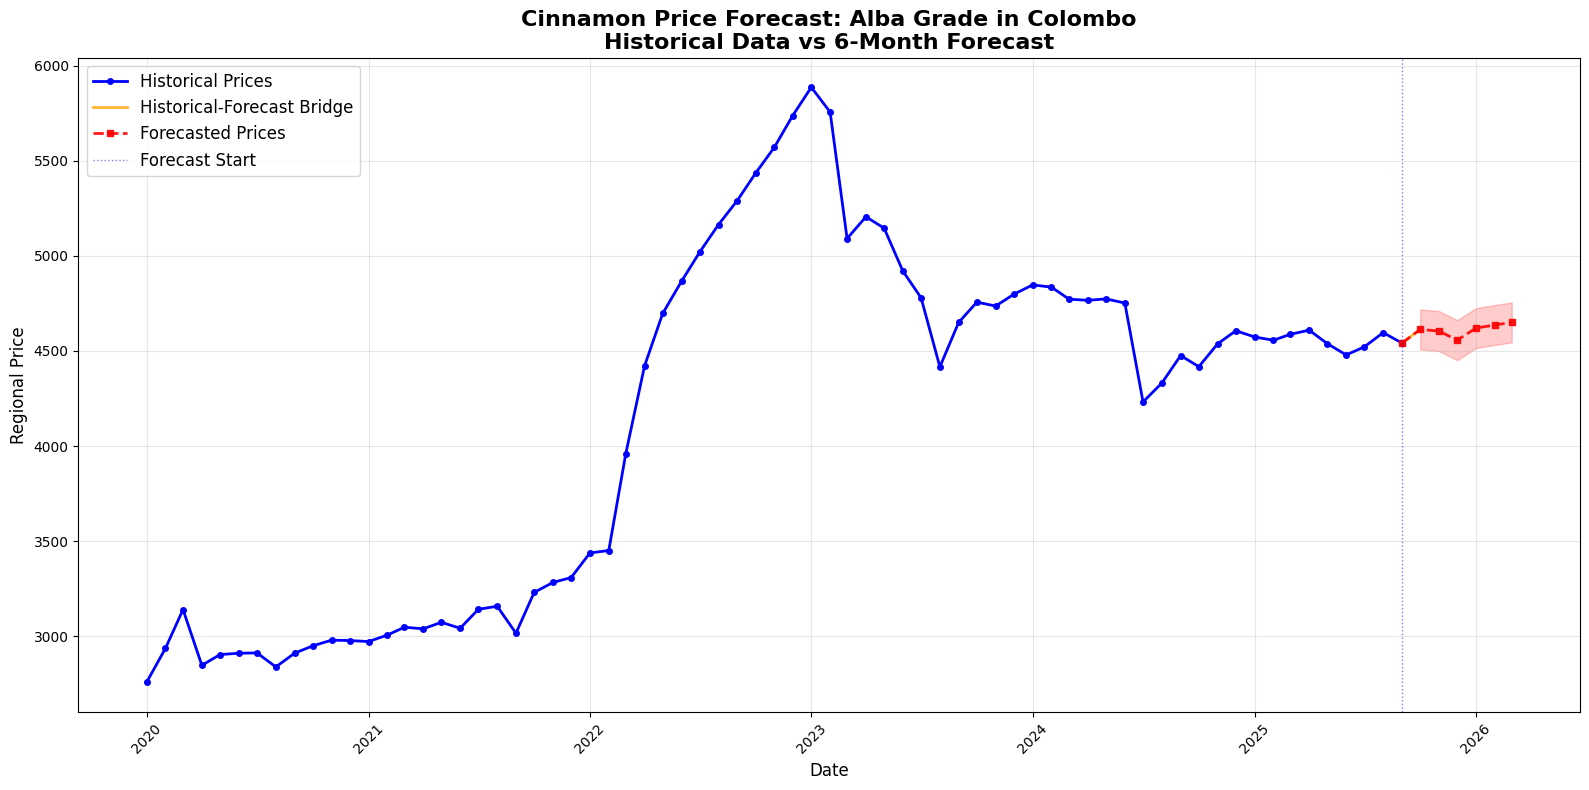


Alba Grade Forecast for Colombo:
Month  1 (2025-10): LKR. 4612.53
Month  2 (2025-11): LKR. 4604.25
Month  3 (2025-12): LKR. 4556.16
Month  4 (2026-01): LKR. 4619.69
Month  5 (2026-02): LKR. 4636.36
Month  6 (2026-03): LKR. 4649.54

Forecast Statistics:
Average Forecast Price: LKR.4613.09
Price Range: LKR.4556.16 - LKR.4649.54
Overall Trend: increasing by LKR.6.17 per month

📈 Generating forecast for c4 in galle...


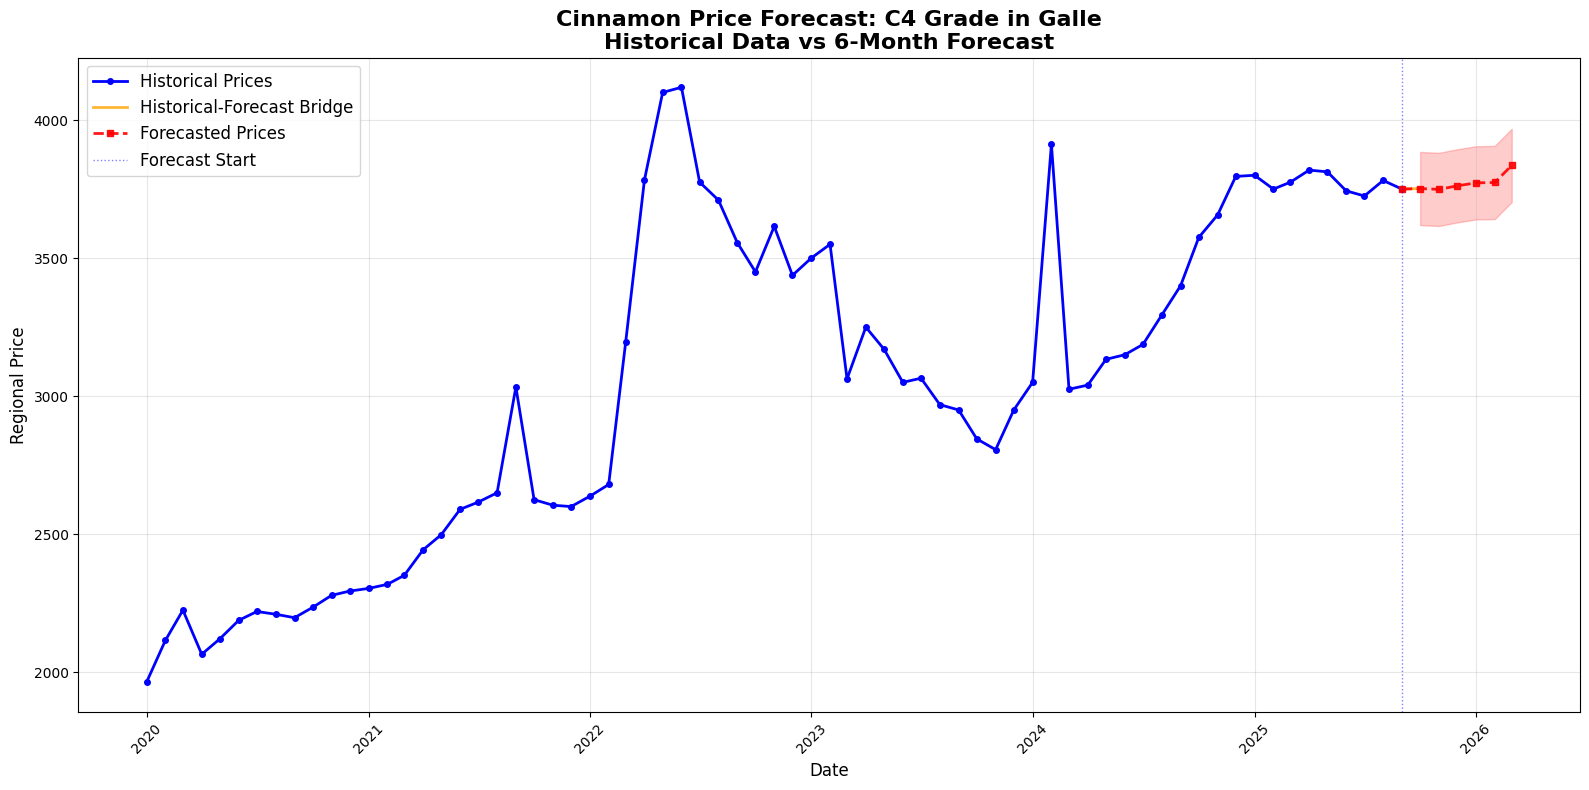


C4 Grade Forecast for Galle:
Month  1 (2025-10): LKR. 3751.92
Month  2 (2025-11): LKR. 3748.92
Month  3 (2025-12): LKR. 3761.60
Month  4 (2026-01): LKR. 3772.56
Month  5 (2026-02): LKR. 3773.87
Month  6 (2026-03): LKR. 3835.81

Forecast Statistics:
Average Forecast Price: LKR.3774.11
Price Range: LKR.3748.92 - LKR.3835.81
Overall Trend: increasing by LKR.13.98 per month


In [19]:
available_grades = df['Grade'].unique()
available_regions = df['Region'].unique()

print(f"Available grades: {available_grades}")
print(f"Available regions: {available_regions}")

# Generate forecast for first combination
if len(available_grades) > 0 and len(available_regions) > 0:
    grade_to_forecast = available_grades[0]
    region_to_forecast = available_regions[0]
    
    print(f"\n📈 Generating forecast for {grade_to_forecast} in {region_to_forecast}...")
    forecasts1, future_dates1 = plot_forecast_results(
        df, model, grade_to_forecast, region_to_forecast, months_ahead=6
    )

# Try another combination if available
if len(available_grades) > 1 and len(available_regions) > 1:
    grade_to_forecast2 = available_grades[1] if len(available_grades) > 1 else available_grades[0]
    region_to_forecast2 = available_regions[1] if len(available_regions) > 1 else available_regions[0]
    
    print(f"\n📈 Generating forecast for {grade_to_forecast2} in {region_to_forecast2}...")
    forecasts2, future_dates2 = plot_forecast_results(
        df, model, grade_to_forecast2, region_to_forecast2, months_ahead=6
    )

# 20. Interactive Forecast Generation


🔮 Interactive Forecast Generation

Available Grades:
1. alba
2. c4
3. c5
4. c5sp
5. h1
6. h2
7. h_faq

Available Regions:
1. colombo
2. galle
3. hambantota
4. kalutara
5. matara
6. ratnapura

📊 Generating 6-month forecast for alba in ratnapura...


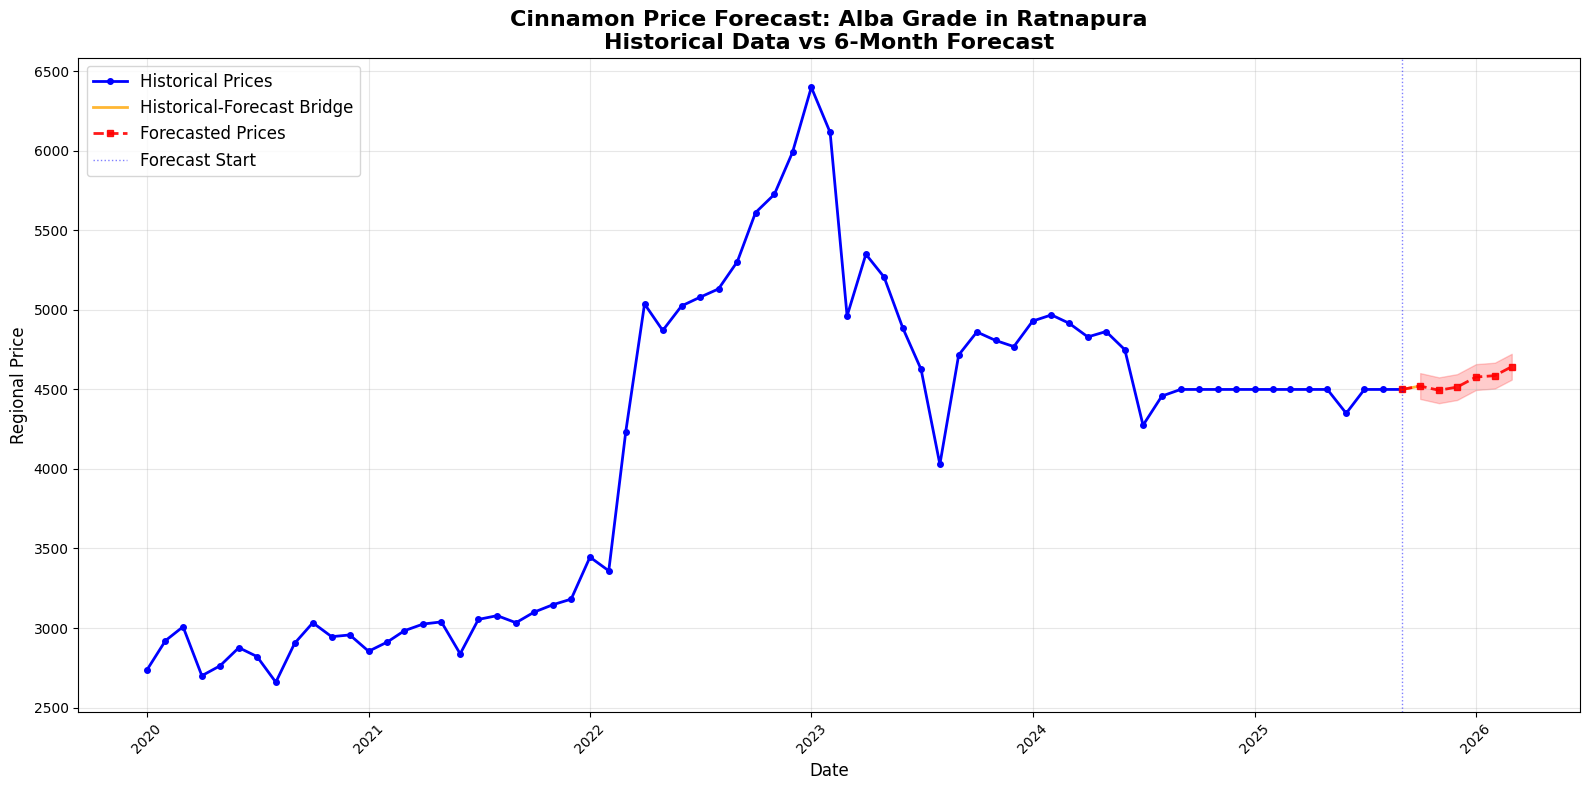


Alba Grade Forecast for Ratnapura:
Month  1 (2025-10): LKR. 4521.46
Month  2 (2025-11): LKR. 4494.72
Month  3 (2025-12): LKR. 4515.02
Month  4 (2026-01): LKR. 4577.88
Month  5 (2026-02): LKR. 4586.81
Month  6 (2026-03): LKR. 4643.03

Forecast Statistics:
Average Forecast Price: LKR.4556.49
Price Range: LKR.4494.72 - LKR.4643.03
Overall Trend: increasing by LKR.20.26 per month


([np.float32(4521.465),
  np.float32(4494.7236),
  np.float32(4515.0176),
  np.float32(4577.884),
  np.float32(4586.8086),
  np.float32(4643.0293)],
 DatetimeIndex(['2025-10-01', '2025-11-01', '2025-12-01', '2026-01-01',
                '2026-02-01', '2026-03-01'],
               dtype='datetime64[ns]', freq='MS'))

In [20]:
def interactive_forecast():
    """Allow user to select grade and region for forecasting"""
    print("\n🔮 Interactive Forecast Generation")
    print("=" * 50)
    
    # Display available options
    print("\nAvailable Grades:")
    for i, grade in enumerate(available_grades, 1):
        print(f"{i}. {grade}")
    
    print("\nAvailable Regions:")
    for i, region in enumerate(available_regions, 1):
        print(f"{i}. {region}")
    
    # Get user input
    try:
        grade_idx = int(input("\nSelect grade number: ")) - 1
        region_idx = int(input("Select region number: ")) - 1
        months = int(input("How many months to forecast (default 6): ") or "6")
        
        if 0 <= grade_idx < len(available_grades) and 0 <= region_idx < len(available_regions):
            selected_grade = available_grades[grade_idx]
            selected_region = available_regions[region_idx]
            
            print(f"\n📊 Generating {months}-month forecast for {selected_grade} in {selected_region}...")
            forecasts, dates = plot_forecast_results(
                df, model, selected_grade, selected_region, months_ahead=months
            )
            return forecasts, dates
        else:
            print("Invalid selection. Please try again.")
            return None, None
            
    except (ValueError, IndexError) as e:
        print(f"Error: {e}. Please enter valid numbers.")
        return None, None

interactive_forecast()

# 21.Hyperparameter Tuning Summary

In [21]:
print("🎯 HYPERPARAMETER TUNING SUMMARY")
print("="*80)

if metrics.get('tuning_used'):
    print(f"✅ Hyperparameter tuning was performed using: {metrics['tuning_method']}")
    print(f"🏆 Best parameters found:")
    for key, value in metrics['best_params'].items():
        print(f"   • {key}: {value}")
    print(f"\n📊 Final Model Performance:")
    print(f"   • MAE: {metrics['mae']:.4f}")
    print(f"   • RMSE: {metrics['rmse']:.4f}")
    print(f"   • R²: {metrics['r2']:.4f}")
    print(f"   • Training epochs: {metrics['epochs_trained']}")
else:
    print("❌ Hyperparameter tuning was skipped - default parameters used")

print("\n💡 To use different tuning methods, modify these variables:")
print("   • USE_HYPERPARAMETER_TUNING = True/False")
print("   • TUNING_METHOD = 'optuna'/'grid'/'random'")  
print("   • N_TUNING_TRIALS = number of trials")

🎯 HYPERPARAMETER TUNING SUMMARY
✅ Hyperparameter tuning was performed using: optuna
🏆 Best parameters found:
   • units1: 256
   • units2: 256
   • dropout1: 0.1
   • dropout2: 0.1
   • dense_units: 32
   • learning_rate: 0.003536146115852421
   • layer_type: GRU
   • use_batch_norm: False
   • optimizer: adam

📊 Final Model Performance:
   • MAE: 74.7872
   • RMSE: 108.2437
   • R²: 0.9841
   • Training epochs: 53

💡 To use different tuning methods, modify these variables:
   • USE_HYPERPARAMETER_TUNING = True/False
   • TUNING_METHOD = 'optuna'/'grid'/'random'
   • N_TUNING_TRIALS = number of trials
